In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Accelerating VQEs with quantum natural gradient
===============================================

::: {.meta}
:property=\"og:description\": Accelerating variational quantum
eigensolvers using quantum natural gradients in PennyLane.
:property=\"og:image\":
<https://pennylane.ai/qml/_images/qng_example.png>
:::

::: {.related}
tutorial\_vqe A brief overview of VQE
tutorial\_quantum\_natural\_gradient Quantum natural gradient
:::

*Authors: Maggie Li, Lana Bozanic, Sukin Sim --- Posted: 06 November
2020. Last updated: 08 April 2021.*

This tutorial showcases how one can apply quantum natural gradients
(QNG) to accelerate the optimization step of the Variational Quantum
Eigensolver (VQE) algorithm. We will implement two small examples:
estimating the ground state energy of a single-qubit VQE problem, which
we can visualize using the Bloch sphere, and the hydrogen molecule.

Before going through this tutorial, we recommend that readers refer to
the
`QNG tutorial </demos/tutorial_quantum_natural_gradient>`{.interpreted-text
role="doc"} and `VQE tutorial </demos/tutorial_vqe>`{.interpreted-text
role="doc"} for overviews of quantum natural gradient and the
variational quantum eigensolver algorithm, respectively. Let\'s get
started!

Single-qubit VQE example
------------------------

The first step is to import the required libraries and packages:


In [45]:
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml

from numpy.linalg import eig

For this simple example, we consider the following single-qubit
Hamiltonian: $\sigma_x + \sigma_z$.

We define the device:


In [46]:
# Set up the parameters
qubits = 4  # grid size

n = qubits
dx = 1.0/n  # grid spacing

# Set up the difference operator
D = np.zeros((n**2, n**2))
for i in range(n):
    for j in range(n):
        k = i*n + j
        if i > 0:
            D[k, (i-1)*n + j] += 1
        if i < n-1:
            D[k, (i+1)*n + j] += 1
        if j > 0:
            D[k, i*n + j-1] += 1
        if j < n-1:
            D[k, i*n + j+1] += 1
        D[k, k] -= 4

# # Print the final solution
print(D)

l, v = eig(D)

egs = np.array(sorted(l))

print('\n', egs)

# try adding in numbers that don't break hermitian to see how eigs change

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4. 

In [47]:
H = qml.pauli_decompose(D)

print(H)

  (-4.0) [I0 I1 I2 I3]
+ (0.5) [I0 I1 X2 X3]
+ (0.5) [I0 I1 Y2 Y3]
+ (0.5) [X0 X1 I2 I3]
+ (0.5) [Y0 Y1 I2 I3]
+ (1.0) [I0 I1 I2 X3]
+ (1.0) [I0 X1 I2 I3]


In [48]:
dev = qml.device("default.qubit", wires=4)

For the variational ansatz, we use two single-qubit rotations, which the
user may recognize from a previous
`tutorial </demos/tutorial_qubit_rotation>`{.interpreted-text
role="doc"} on qubit rotations.


In [49]:
def circuit(params, wires=4):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=1)
    qml.RX(params[4], wires=2)
    qml.RY(params[5], wires=2)
    qml.RX(params[6], wires=3)
    qml.RY(params[7], wires=3)
    
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

In [50]:
# Wieghts

#Lower values of weights seems to be a little better

seednum = 3999

np.random.seed(seednum)

# randw = np.random.uniform(0.0001,2,8)
randw = np.random.uniform(-np.pi, np.pi, 8)

print(randw)

# for 4 qubits 0.5554565  [1.34757202 1.96211005 1.12726619] convereged to approx -5.5

# [1.26190158 0.23128387 0.4608764  0.62664839 0.02505982 1.94600236 1.11482688 0.842671  ]

[-1.66614016 -1.57717471  2.21361417 -2.52252641  0.64674042 -0.53984692
  1.62930463 -0.56974259]


We then define our cost function which supports the computation of
block-diagonal or diagonal approximations to the Fubini-Study metric
tensor. This tensor is a crucial component for optimizing with quantum
natural gradients.


In [51]:
@qml.qnode(dev, interface="autograd")
def cost_fn(params):
    circuit(params)
    return qml.expval(H)

To analyze the performance of quantum natural gradient on VQE
calculations, we set up and execute optimizations using the
`GradientDescentOptimizer` (which does not utilize quantum gradients)
and the `QNGOptimizer` that uses the block-diagonal approximation to the
metric tensor.

To perform a fair comparison, we fix the initial parameters for the two
optimizers.


In [52]:
init_params = np.array(randw, requires_grad=True)

We will carry out each optimization over a maximum of 500 steps. As was
done in the VQE tutorial, we aim to reach a convergence tolerance of
around $10^{-6}$. We use a step size of 0.01.


In [53]:
max_iterations = 1000
conv_tol = 0.001
step_size = 0.1

First, we carry out the VQE optimization using the standard gradient
descent method.


In [54]:
# 3999 converges to -7.10981984

# 45999 converges -6.50049932

opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for i in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if i % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(i, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Lowest eigen value = {:.3f} ".format(min(l)))
print("Number of iterations = ", i)

Iteration = 0,  Energy = -4.39415066 Ha,  Convergence parameter = 0.07758229 Ha
Iteration = 20,  Energy = -6.26606820 Ha,  Convergence parameter = 0.06334340 Ha
Iteration = 40,  Energy = -6.94904419 Ha,  Convergence parameter = 0.01872144 Ha
Iteration = 60,  Energy = -7.10584468 Ha,  Convergence parameter = 0.00191810 Ha

Final value of the energy = -7.11221372 Ha
Lowest eigen value = -7.236 
Number of iterations =  65


We then repeat the process for the optimizer employing quantum natural
gradients:


In [55]:
opt = qml.QNGOptimizer(stepsize=step_size, approx="block-diag")

params = init_params

qngd_param_history = [params]
qngd_cost_history = []

for n in range(max_iterations):

    # Take step
    params, prev_energy = opt.step_and_cost(cost_fn, params)
    qngd_param_history.append(params)
    qngd_cost_history.append(prev_energy)

    # Compute energy
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if i % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
            ":.8f} Ha".format(i, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} Ha".format(energy))
print("Number of iterations = ", i)


Final value of the energy = -7.11748531 Ha
Number of iterations =  65


Visualizing the results
=======================

For single-qubit examples, we can visualize the optimization process in
several ways.

For example, we can track the energy history:


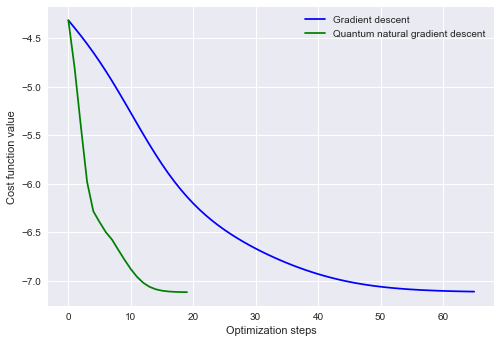

In [56]:
plt.style.use("seaborn")
plt.plot(gd_cost_history, "b", label="Gradient descent")
plt.plot(qngd_cost_history, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

Or we can visualize the optimization path in the parameter space using a
contour plot. Energies at different grid points have been pre-computed,
and they can be downloaded by clicking
`here<../demonstrations/vqe_qng/param_landscape.npy>`{.interpreted-text
role="download"}.


In [57]:
# Tryign to run multiple times to gain statistics

final_E = [] # Matrix to store final energy
gd_param_history = [params] # matrix to store parameters
gd_cost_history = [] # matrix to store cost function

# random seed for reproducability
seednum = 999 
np.random.seed(seednum)

# assigning random parameters to circuit
init_params = np.array(randw, requires_grad=True)
params = init_params
conv = 0

opt = qml.GradientDescentOptimizer(stepsize=step_size)



counter = 0

for r in range(100):
    
    gd_param_history = [params]
    gd_cost_history = []
    
    for i in range(max_iterations):

        # Take step
        params, prev_energy = opt.step_and_cost(cost_fn, params)
        gd_param_history.append(params)
        gd_cost_history.append(prev_energy)

        energy = cost_fn(params)

        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)

#         if i % 20 == 0:
#             print(
#                 "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
#                 ":.8f} Ha".format(i, energy, conv)
#             )

        if conv <= conv_tol:
            break

    
    final_E.append(energy)
    print()
    print("Run {}".format(r))
    print("Final value of the energy = {:.8f} Ha".format(energy))
    print("Number of iterations = ", i)
    
    # Resetting Weights for next run
    np.random.seed(seednum*(r+2))
    randw = np.random.uniform(0.0001,2,12)
    init_params = np.array(randw, requires_grad=True)
    params = init_params


Run 0
Final value of the energy = -7.11221372 Ha
Number of iterations =  65

Run 1
Final value of the energy = -7.11171208 Ha
Number of iterations =  119

Run 2
Final value of the energy = -7.11005812 Ha
Number of iterations =  110

Run 3
Final value of the energy = -7.10918776 Ha
Number of iterations =  135

Run 4
Final value of the energy = -6.11292225 Ha
Number of iterations =  64

Run 5
Final value of the energy = -6.11201126 Ha
Number of iterations =  52

Run 6
Final value of the energy = -6.11169839 Ha
Number of iterations =  86

Run 7
Final value of the energy = -6.10980308 Ha
Number of iterations =  50

Run 8
Final value of the energy = -7.10947709 Ha
Number of iterations =  74

Run 9
Final value of the energy = -6.11062843 Ha
Number of iterations =  56

Run 10
Final value of the energy = -7.11136081 Ha
Number of iterations =  78

Run 11
Final value of the energy = -7.11234032 Ha
Number of iterations =  88

Run 12
Final value of the energy = -6.11193676 Ha
Number of iterations

-7.236067977499786
-6.236067977499788
-6.2360679774997845
-5.236067977499794
-5.000000000000008
-5.000000000000003
-4.000000000000002
-4.000000000000001
-3.999999999999999
-3.9999999999999973
-3.0000000000000018
-3.0
-2.763932022500217
-1.7639320225002117
-1.7639320225002098
-0.7639320225002111


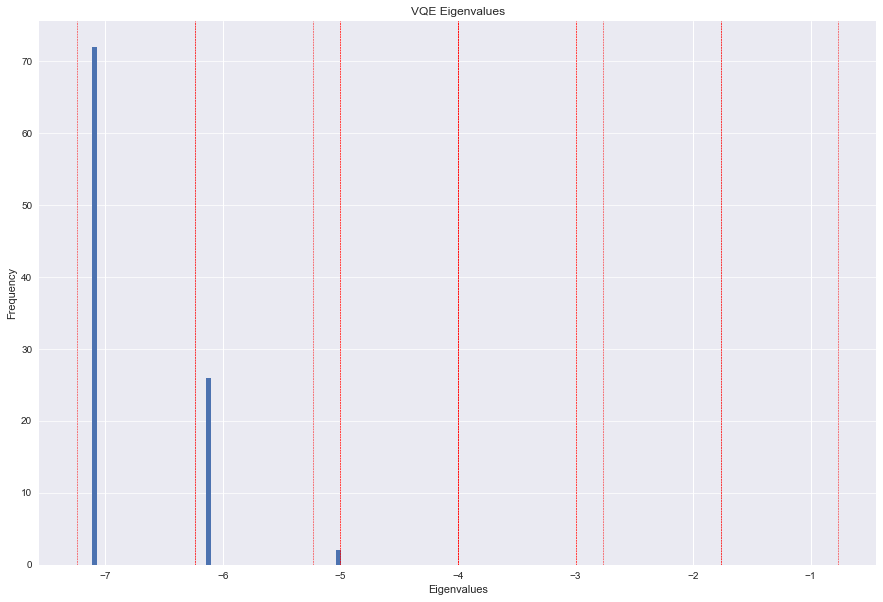

In [58]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.hist(np.array(final_E), 50)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.title('VQE Eigenvalues')

for i in range(len(egs)):
    plt.axvline(egs[i], linewidth=0.5, color='r', ls = '--')
    print(egs[i])

Iteration = 0,  Energy = -3.99464356 Ha,  Convergence parameter = 0.08845436 Ha
Iteration = 20,  Energy = -5.95420161 Ha,  Convergence parameter = 0.06935226 Ha
Iteration = 40,  Energy = -6.39598133 Ha,  Convergence parameter = 0.00838069 Ha
Iteration = 60,  Energy = -6.58499754 Ha,  Convergence parameter = 0.01206355 Ha
Iteration = 80,  Energy = -6.87734915 Ha,  Convergence parameter = 0.01451695 Ha
Iteration = 100,  Energy = -7.06935101 Ha,  Convergence parameter = 0.00490247 Ha

Final value of the energy = -7.10957301 Ha
Number of iterations =  117
Iteration = 0,  Energy = -4.08604268 Ha,  Convergence parameter = 0.10739909 Ha
Iteration = 20,  Energy = -5.00506414 Ha,  Convergence parameter = 0.01413464 Ha
Iteration = 40,  Energy = -5.34650215 Ha,  Convergence parameter = 0.02704237 Ha
Iteration = 60,  Energy = -6.28097528 Ha,  Convergence parameter = 0.03913680 Ha
Iteration = 80,  Energy = -6.52302830 Ha,  Convergence parameter = 0.00436828 Ha
Iteration = 100,  Energy = -6.69851820

Iteration = 20,  Energy = -5.95506741 Ha,  Convergence parameter = 0.09592190 Ha
Iteration = 40,  Energy = -6.57848142 Ha,  Convergence parameter = 0.01472434 Ha
Iteration = 60,  Energy = -6.88080922 Ha,  Convergence parameter = 0.01406625 Ha
Iteration = 80,  Energy = -7.06820586 Ha,  Convergence parameter = 0.00490150 Ha

Final value of the energy = -7.10911385 Ha
Number of iterations =  97
Iteration = 0,  Energy = -3.19110099 Ha,  Convergence parameter = 0.15519091 Ha
Iteration = 20,  Energy = -6.08175668 Ha,  Convergence parameter = 0.06048992 Ha
Iteration = 40,  Energy = -6.54189361 Ha,  Convergence parameter = 0.01206202 Ha
Iteration = 60,  Energy = -6.87238852 Ha,  Convergence parameter = 0.01800458 Ha
Iteration = 80,  Energy = -7.08355499 Ha,  Convergence parameter = 0.00420703 Ha

Final value of the energy = -7.11065703 Ha
Number of iterations =  93
Iteration = 0,  Energy = -3.83114342 Ha,  Convergence parameter = 0.11599255 Ha
Iteration = 20,  Energy = -6.51890527 Ha,  Converg

Iteration = 60,  Energy = -6.54344807 Ha,  Convergence parameter = 0.01913966 Ha
Iteration = 80,  Energy = -6.96038489 Ha,  Convergence parameter = 0.01634807 Ha
Iteration = 100,  Energy = -7.10449286 Ha,  Convergence parameter = 0.00195061 Ha

Final value of the energy = -7.11114944 Ha
Number of iterations =  105
Iteration = 0,  Energy = -2.98231863 Ha,  Convergence parameter = 0.11585120 Ha
Iteration = 20,  Energy = -5.62444401 Ha,  Convergence parameter = 0.06096277 Ha
Iteration = 40,  Energy = -6.56274722 Ha,  Convergence parameter = 0.02663015 Ha
Iteration = 60,  Energy = -6.90338837 Ha,  Convergence parameter = 0.01300041 Ha
Iteration = 80,  Energy = -7.07277332 Ha,  Convergence parameter = 0.00439393 Ha

Final value of the energy = -7.10973898 Ha
Number of iterations =  97
Iteration = 0,  Energy = -3.13977139 Ha,  Convergence parameter = 0.03070775 Ha
Iteration = 20,  Energy = -4.90443328 Ha,  Convergence parameter = 0.06180957 Ha
Iteration = 40,  Energy = -5.40412040 Ha,  Conve

Iteration = 20,  Energy = -5.47441467 Ha,  Convergence parameter = 0.06508050 Ha
Iteration = 40,  Energy = -6.65050141 Ha,  Convergence parameter = 0.02758399 Ha
Iteration = 60,  Energy = -7.02980601 Ha,  Convergence parameter = 0.01030772 Ha
Iteration = 80,  Energy = -7.11065240 Ha,  Convergence parameter = 0.00101372 Ha

Final value of the energy = -7.11154304 Ha
Number of iterations =  81
Iteration = 0,  Energy = -2.97641178 Ha,  Convergence parameter = 0.05587115 Ha
Iteration = 20,  Energy = -4.64116782 Ha,  Convergence parameter = 0.13136232 Ha
Iteration = 40,  Energy = -6.71713157 Ha,  Convergence parameter = 0.03528578 Ha
Iteration = 60,  Energy = -7.06410676 Ha,  Convergence parameter = 0.00692126 Ha

Final value of the energy = -7.11112300 Ha
Number of iterations =  76
Iteration = 0,  Energy = -3.72082936 Ha,  Convergence parameter = 0.03361417 Ha
Iteration = 20,  Energy = -4.74041641 Ha,  Convergence parameter = 0.04932871 Ha
Iteration = 40,  Energy = -5.20757638 Ha,  Converg

Iteration = 100,  Energy = -6.77708026 Ha,  Convergence parameter = 0.01535174 Ha
Iteration = 120,  Energy = -7.02009171 Ha,  Convergence parameter = 0.00816945 Ha
Iteration = 140,  Energy = -7.10301345 Ha,  Convergence parameter = 0.00161122 Ha

Final value of the energy = -7.10906438 Ha
Number of iterations =  145
Iteration = 0,  Energy = -2.86936154 Ha,  Convergence parameter = 0.19026636 Ha
Iteration = 20,  Energy = -5.25444685 Ha,  Convergence parameter = 0.03019660 Ha
Iteration = 40,  Energy = -5.56545060 Ha,  Convergence parameter = 0.01444947 Ha
Iteration = 60,  Energy = -5.98365048 Ha,  Convergence parameter = 0.02135979 Ha
Iteration = 80,  Energy = -6.22808366 Ha,  Convergence parameter = 0.00736238 Ha
Iteration = 100,  Energy = -6.36147269 Ha,  Convergence parameter = 0.00596568 Ha
Iteration = 120,  Energy = -6.45007807 Ha,  Convergence parameter = 0.00298279 Ha
Iteration = 140,  Energy = -6.48600913 Ha,  Convergence parameter = 0.00099076 Ha

Final value of the energy = -6.

Iteration = 40,  Energy = -6.54829761 Ha,  Convergence parameter = 0.02028601 Ha
Iteration = 60,  Energy = -6.87453121 Ha,  Convergence parameter = 0.01510215 Ha
Iteration = 80,  Energy = -7.07094180 Ha,  Convergence parameter = 0.00486348 Ha

Final value of the energy = -7.11010722 Ha
Number of iterations =  97
Iteration = 0,  Energy = -2.60608708 Ha,  Convergence parameter = 0.12842722 Ha
Iteration = 20,  Energy = -5.32377926 Ha,  Convergence parameter = 0.08158421 Ha
Iteration = 40,  Energy = -6.02270008 Ha,  Convergence parameter = 0.01087614 Ha
Iteration = 60,  Energy = -6.10783837 Ha,  Convergence parameter = 0.00122665 Ha

Final value of the energy = -6.10990996 Ha
Number of iterations =  62
Iteration = 0,  Energy = -3.10724670 Ha,  Convergence parameter = 0.12857291 Ha
Iteration = 20,  Energy = -4.91003482 Ha,  Convergence parameter = 0.04775940 Ha
Iteration = 40,  Energy = -6.49619218 Ha,  Convergence parameter = 0.07868271 Ha
Iteration = 60,  Energy = -7.00705726 Ha,  Converg

Iteration = 100,  Energy = -7.10873785 Ha,  Convergence parameter = 0.00101364 Ha

Final value of the energy = -7.10965431 Ha
Number of iterations =  101
Iteration = 0,  Energy = -4.04083162 Ha,  Convergence parameter = 0.14151994 Ha
Iteration = 20,  Energy = -5.25669590 Ha,  Convergence parameter = 0.04204265 Ha
Iteration = 40,  Energy = -6.16251377 Ha,  Convergence parameter = 0.01708652 Ha
Iteration = 60,  Energy = -6.33236045 Ha,  Convergence parameter = 0.00648931 Ha
Iteration = 80,  Energy = -6.43500518 Ha,  Convergence parameter = 0.00369251 Ha
Iteration = 100,  Energy = -6.48228862 Ha,  Convergence parameter = 0.00146982 Ha
Iteration = 120,  Energy = -6.51006176 Ha,  Convergence parameter = 0.00192212 Ha
Iteration = 140,  Energy = -6.61441186 Ha,  Convergence parameter = 0.01003401 Ha
Iteration = 160,  Energy = -6.90860105 Ha,  Convergence parameter = 0.01488660 Ha
Iteration = 180,  Energy = -7.08402253 Ha,  Convergence parameter = 0.00377434 Ha

Final value of the energy = -7.

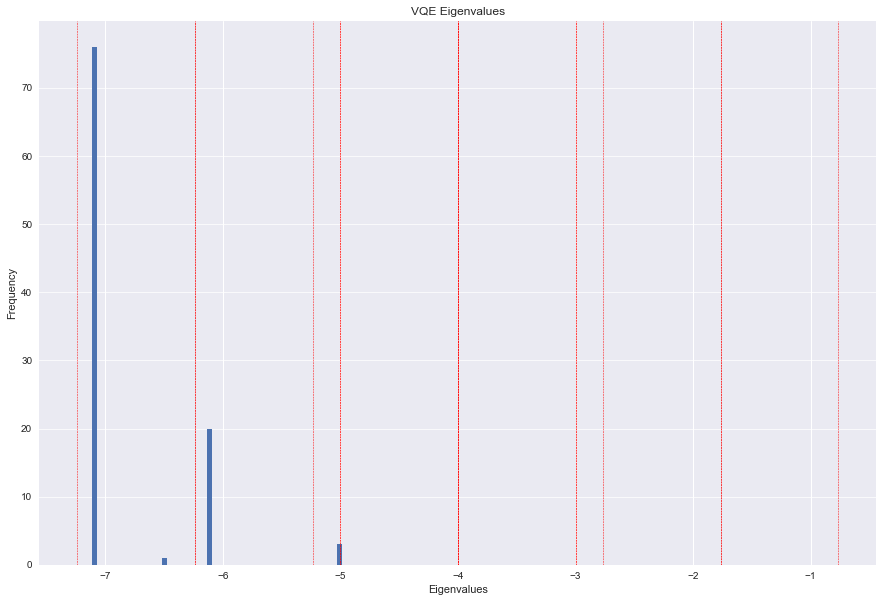

In [103]:
# Running multiple times to gain statistics

final_E = []

for r in range(100):
    
    for i in range(max_iterations):

        # Take step
        params, prev_energy = opt.step_and_cost(cost_fn, params)
        gd_param_history.append(params)
        gd_cost_history.append(prev_energy)

        energy = cost_fn(params)

        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)

        if i % 20 == 0:
            print(
                "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
                ":.8f} Ha".format(i, energy, conv)
            )

        if conv <= conv_tol:
            break
    
    final_E.append(energy)
    print()
    print("Final value of the energy = {:.8f} Ha".format(energy))
    print("Number of iterations = ", i)
    
    # Resetting Weights for next run
    np.random.seed(seednum*(r+7))
    randw = np.random.uniform(0.0001,2,12)
    init_params = np.array(randw, requires_grad=True)
    params = init_params
    
    
plt.rcParams['figure.figsize'] = [15, 10]
plt.hist(np.array(final_E), 50)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.title('VQE Eigenvalues')

for i in range(len(egs)):
    plt.axvline(egs[i], linewidth=0.5, color='r', ls = '--')
    print(egs[i])

In [60]:
# Tryign to run multiple times to gain statistics with decrease in conv tol and step size
max_iterations = 2000
conv_tol = 0.1
step_size = 0.1


final_E = [] # Matrix to store final energy

# random seed for reproducability
seednum = 3999 
np.random.seed(seednum)
conv = 0

# assigning random parameters to circuit
init_params = np.array(randw, requires_grad=True)
params = init_params
opt = qml.GradientDescentOptimizer(stepsize=step_size)

for r in range(100):
    
    gd_param_history = [params]
    gd_cost_history = []
    conv_tol = 0.001
    step_size = 0.1
    counter = 0
    
    for i in range(max_iterations):

        # Take step
        params, prev_energy = opt.step_and_cost(cost_fn, params)
        gd_param_history.append(params)
        gd_cost_history.append(prev_energy)

        energy = cost_fn(params)

        # Calculate difference between new and old energies
        conv = np.abs(energy - prev_energy)

        if i % 20 == 0:
            print(
                "Iteration = {:},  Energy = {:.8f} Ha,  Convergence parameter = {"
                ":.8f} Ha".format(i, energy, conv)
            )

        if conv <= conv_tol:
        
            conv_tol = conv_tol/10
            step_size = step_size/10
            opt = qml.GradientDescentOptimizer(stepsize=step_size)
            counter = counter + 1
            
            print()
            print("Convergence tolerance decrease {}, conv = {}".format(counter, conv))

        if counter == 10:
            break


    
    final_E.append(energy)
    print()
    print("Run {}".format(r))
    print("Final value of the energy = {:.8f} Ha".format(energy))
    print("Number of iterations = ", i)
    
    # Resetting Weights for next run
    np.random.seed(seednum*(r+2))
    randw = np.random.uniform(0.0001,2,12)
    init_params = np.array(randw, requires_grad=True)
    params = init_params

Iteration = 0,  Energy = -3.94866493 Ha,  Convergence parameter = 0.09011707 Ha
Iteration = 20,  Energy = -4.99432624 Ha,  Convergence parameter = 0.00956377 Ha
Iteration = 40,  Energy = -5.21132103 Ha,  Convergence parameter = 0.02313811 Ha
Iteration = 60,  Energy = -6.02063263 Ha,  Convergence parameter = 0.02223472 Ha

Convergence tolerance decrease 1, conv = 0.0008435856769981598

Convergence tolerance decrease 2, conv = 7.02962189480516e-05

Convergence tolerance decrease 3, conv = 6.9098002075662635e-06

Convergence tolerance decrease 4, conv = 6.897997479882179e-07

Convergence tolerance decrease 5, conv = 6.896818760537826e-08
Iteration = 80,  Energy = -6.11489013 Ha,  Convergence parameter = 0.00000001 Ha

Convergence tolerance decrease 6, conv = 6.8966992117225345e-09

Convergence tolerance decrease 7, conv = 6.896732074324063e-10

Convergence tolerance decrease 8, conv = 6.896616611129502e-11

Convergence tolerance decrease 9, conv = 6.894929072132072e-12

Convergence tolera

Iteration = 460,  Energy = -6.04545115 Ha,  Convergence parameter = 0.00616808 Ha
Iteration = 480,  Energy = -6.15991905 Ha,  Convergence parameter = 0.00529009 Ha
Iteration = 500,  Energy = -6.25553380 Ha,  Convergence parameter = 0.00432129 Ha
Iteration = 520,  Energy = -6.33241410 Ha,  Convergence parameter = 0.00343506 Ha
Iteration = 540,  Energy = -6.39331968 Ha,  Convergence parameter = 0.00272346 Ha
Iteration = 560,  Energy = -6.44203830 Ha,  Convergence parameter = 0.00220538 Ha
Iteration = 580,  Energy = -6.48224618 Ha,  Convergence parameter = 0.00185825 Ha
Iteration = 600,  Energy = -6.51698203 Ha,  Convergence parameter = 0.00164509 Ha
Iteration = 620,  Energy = -6.54853410 Ha,  Convergence parameter = 0.00152934 Ha
Iteration = 640,  Energy = -6.57851715 Ha,  Convergence parameter = 0.00148031 Ha
Iteration = 660,  Energy = -6.60800224 Ha,  Convergence parameter = 0.00147391 Ha
Iteration = 680,  Energy = -6.63763966 Ha,  Convergence parameter = 0.00149167 Ha
Iteration = 700,

Iteration = 40,  Energy = -3.64491628 Ha,  Convergence parameter = 0.00880968 Ha
Iteration = 60,  Energy = -3.81729465 Ha,  Convergence parameter = 0.00848609 Ha
Iteration = 80,  Energy = -3.98570736 Ha,  Convergence parameter = 0.00839021 Ha
Iteration = 100,  Energy = -4.15347178 Ha,  Convergence parameter = 0.00838479 Ha
Iteration = 120,  Energy = -4.32027552 Ha,  Convergence parameter = 0.00826738 Ha
Iteration = 140,  Energy = -4.48218700 Ha,  Convergence parameter = 0.00789511 Ha
Iteration = 160,  Energy = -4.63382963 Ha,  Convergence parameter = 0.00726520 Ha
Iteration = 180,  Energy = -4.77117920 Ha,  Convergence parameter = 0.00649914 Ha
Iteration = 200,  Energy = -4.89323655 Ha,  Convergence parameter = 0.00576083 Ha
Iteration = 220,  Energy = -5.00203922 Ha,  Convergence parameter = 0.00518298 Ha
Iteration = 240,  Energy = -5.10167336 Ha,  Convergence parameter = 0.00483982 Ha
Iteration = 260,  Energy = -5.19714348 Ha,  Convergence parameter = 0.00475406 Ha
Iteration = 280,  E

Iteration = 760,  Energy = -6.98873369 Ha,  Convergence parameter = 0.00101044 Ha
Iteration = 780,  Energy = -7.00780611 Ha,  Convergence parameter = 0.00090227 Ha
Iteration = 800,  Energy = -7.02472959 Ha,  Convergence parameter = 0.00079594 Ha
Iteration = 820,  Energy = -7.03957014 Ha,  Convergence parameter = 0.00069415 Ha
Iteration = 840,  Energy = -7.05244141 Ha,  Convergence parameter = 0.00059898 Ha
Iteration = 860,  Energy = -7.06349203 Ha,  Convergence parameter = 0.00051187 Ha
Iteration = 880,  Energy = -7.07289275 Ha,  Convergence parameter = 0.00043363 Ha
Iteration = 900,  Energy = -7.08082462 Ha,  Convergence parameter = 0.00036453 Ha
Iteration = 920,  Energy = -7.08746902 Ha,  Convergence parameter = 0.00030438 Ha
Iteration = 940,  Energy = -7.09300023 Ha,  Convergence parameter = 0.00025268 Ha
Iteration = 960,  Energy = -7.09758012 Ha,  Convergence parameter = 0.00020873 Ha
Iteration = 980,  Energy = -7.10135519 Ha,  Convergence parameter = 0.00017171 Ha
Iteration = 1000

Iteration = 620,  Energy = -6.53107829 Ha,  Convergence parameter = 0.00235734 Ha
Iteration = 640,  Energy = -6.57541280 Ha,  Convergence parameter = 0.00210272 Ha
Iteration = 660,  Energy = -6.61546983 Ha,  Convergence parameter = 0.00192288 Ha
Iteration = 680,  Energy = -6.65255112 Ha,  Convergence parameter = 0.00179922 Ha
Iteration = 700,  Energy = -6.68759034 Ha,  Convergence parameter = 0.00171402 Ha
Iteration = 720,  Energy = -6.72119520 Ha,  Convergence parameter = 0.00165242 Ha
Iteration = 740,  Energy = -6.75371162 Ha,  Convergence parameter = 0.00160292 Ha
Iteration = 760,  Energy = -6.78528784 Ha,  Convergence parameter = 0.00155704 Ha
Iteration = 780,  Energy = -6.81593021 Ha,  Convergence parameter = 0.00150884 Ha
Iteration = 800,  Energy = -6.84554852 Ha,  Convergence parameter = 0.00145444 Ha
Iteration = 820,  Energy = -6.87399266 Ha,  Convergence parameter = 0.00139160 Ha
Iteration = 840,  Energy = -6.90108240 Ha,  Convergence parameter = 0.00131943 Ha
Iteration = 860,

Iteration = 20,  Energy = -3.76952800 Ha,  Convergence parameter = 0.02107594 Ha
Iteration = 40,  Energy = -4.20262051 Ha,  Convergence parameter = 0.02203225 Ha
Iteration = 60,  Energy = -4.64061437 Ha,  Convergence parameter = 0.02146726 Ha
Iteration = 80,  Energy = -5.04699700 Ha,  Convergence parameter = 0.01903264 Ha
Iteration = 100,  Energy = -5.39269762 Ha,  Convergence parameter = 0.01565483 Ha
Iteration = 120,  Energy = -5.67109212 Ha,  Convergence parameter = 0.01243174 Ha
Iteration = 140,  Energy = -5.89134616 Ha,  Convergence parameter = 0.00983435 Ha
Iteration = 160,  Energy = -6.06620966 Ha,  Convergence parameter = 0.00783886 Ha
Iteration = 180,  Energy = -6.20608860 Ha,  Convergence parameter = 0.00628888 Ha
Iteration = 200,  Energy = -6.31855986 Ha,  Convergence parameter = 0.00506750 Ha
Iteration = 220,  Energy = -6.40946700 Ha,  Convergence parameter = 0.00411158 Ha
Iteration = 240,  Energy = -6.48368766 Ha,  Convergence parameter = 0.00338155 Ha
Iteration = 260,  En

Iteration = 1040,  Energy = -7.10010203 Ha,  Convergence parameter = 0.00019895 Ha
Iteration = 1060,  Energy = -7.10366143 Ha,  Convergence parameter = 0.00016023 Ha
Iteration = 1080,  Energy = -7.10652391 Ha,  Convergence parameter = 0.00012869 Ha
Iteration = 1100,  Energy = -7.10882055 Ha,  Convergence parameter = 0.00010316 Ha

Convergence tolerance decrease 2, conv = 9.977580132591868e-05

Convergence tolerance decrease 3, conv = 9.892012108991821e-06

Convergence tolerance decrease 4, conv = 9.883519345166292e-07

Convergence tolerance decrease 5, conv = 9.882670859440168e-08

Convergence tolerance decrease 6, conv = 9.882584528497773e-09

Convergence tolerance decrease 7, conv = 9.882556994966762e-10

Convergence tolerance decrease 8, conv = 9.882583640319353e-11

Convergence tolerance decrease 9, conv = 9.880984919163893e-12

Convergence tolerance decrease 10, conv = 9.894307595459395e-13

Run 10
Final value of the energy = -7.10913422 Ha
Number of iterations =  1111
Iteration =

Iteration = 560,  Energy = -7.10478881 Ha,  Convergence parameter = 0.00015273 Ha
Iteration = 580,  Energy = -7.10750509 Ha,  Convergence parameter = 0.00012159 Ha

Convergence tolerance decrease 2, conv = 9.889376388816373e-05

Convergence tolerance decrease 3, conv = 9.801527374619923e-06
Iteration = 600,  Energy = -7.10948207 Ha,  Convergence parameter = 0.00000098 Ha

Convergence tolerance decrease 4, conv = 9.792810846676048e-07

Convergence tolerance decrease 5, conv = 9.791939437064912e-08

Convergence tolerance decrease 6, conv = 9.791849109319628e-09

Convergence tolerance decrease 7, conv = 9.791891741883774e-10

Convergence tolerance decrease 8, conv = 9.79154535230009e-11

Convergence tolerance decrease 9, conv = 9.794831612452981e-12

Convergence tolerance decrease 10, conv = 9.78772618509538e-13

Run 12
Final value of the energy = -7.10948218 Ha
Number of iterations =  606
Iteration = 0,  Energy = -2.92179405 Ha,  Convergence parameter = 0.00000000 Ha

Convergence toleran

Iteration = 520,  Energy = -5.71320738 Ha,  Convergence parameter = 0.00855253 Ha
Iteration = 540,  Energy = -5.87735782 Ha,  Convergence parameter = 0.00783460 Ha
Iteration = 560,  Energy = -6.02350577 Ha,  Convergence parameter = 0.00678891 Ha
Iteration = 580,  Energy = -6.14659340 Ha,  Convergence parameter = 0.00556625 Ha
Iteration = 600,  Energy = -6.24491463 Ha,  Convergence parameter = 0.00433972 Ha
Iteration = 620,  Energy = -6.31991837 Ha,  Convergence parameter = 0.00324514 Ha
Iteration = 640,  Energy = -6.37507850 Ha,  Convergence parameter = 0.00235116 Ha
Iteration = 660,  Energy = -6.41458482 Ha,  Convergence parameter = 0.00166716 Ha
Iteration = 680,  Energy = -6.44240982 Ha,  Convergence parameter = 0.00116803 Ha
Iteration = 700,  Energy = -6.46186392 Ha,  Convergence parameter = 0.00081627 Ha
Iteration = 720,  Energy = -6.47550159 Ha,  Convergence parameter = 0.00057520 Ha
Iteration = 740,  Energy = -6.48520511 Ha,  Convergence parameter = 0.00041441 Ha
Iteration = 760,

Iteration = 760,  Energy = -6.79668290 Ha,  Convergence parameter = 0.00150882 Ha
Iteration = 780,  Energy = -6.82642277 Ha,  Convergence parameter = 0.00146575 Ha
Iteration = 800,  Energy = -6.85520025 Ha,  Convergence parameter = 0.00141300 Ha
Iteration = 820,  Energy = -6.88281910 Ha,  Convergence parameter = 0.00135038 Ha
Iteration = 840,  Energy = -6.90908392 Ha,  Convergence parameter = 0.00127817 Ha
Iteration = 860,  Energy = -6.93381122 Ha,  Convergence parameter = 0.00119726 Ha
Iteration = 880,  Energy = -6.95684158 Ha,  Convergence parameter = 0.00110913 Ha
Iteration = 900,  Energy = -6.97805092 Ha,  Convergence parameter = 0.00101579 Ha
Iteration = 920,  Energy = -6.99735922 Ha,  Convergence parameter = 0.00091958 Ha
Iteration = 940,  Energy = -7.01473510 Ha,  Convergence parameter = 0.00082298 Ha
Iteration = 960,  Energy = -7.03019606 Ha,  Convergence parameter = 0.00072836 Ha
Iteration = 980,  Energy = -7.04380436 Ha,  Convergence parameter = 0.00063782 Ha
Iteration = 1000

Iteration = 460,  Energy = -6.64095266 Ha,  Convergence parameter = 0.00327125 Ha
Iteration = 480,  Energy = -6.70282225 Ha,  Convergence parameter = 0.00294469 Ha
Iteration = 500,  Energy = -6.75883865 Ha,  Convergence parameter = 0.00267748 Ha
Iteration = 520,  Energy = -6.80986473 Ha,  Convergence parameter = 0.00243992 Ha
Iteration = 540,  Energy = -6.85626177 Ha,  Convergence parameter = 0.00221161 Ha
Iteration = 560,  Energy = -6.89809305 Ha,  Convergence parameter = 0.00198250 Ha
Iteration = 580,  Energy = -6.93531468 Ha,  Convergence parameter = 0.00175106 Ha
Iteration = 600,  Energy = -6.96791475 Ha,  Convergence parameter = 0.00152120 Ha
Iteration = 620,  Energy = -6.99599008 Ha,  Convergence parameter = 0.00129930 Ha
Iteration = 640,  Energy = -7.01976834 Ha,  Convergence parameter = 0.00109176 Ha
Iteration = 660,  Energy = -7.03959208 Ha,  Convergence parameter = 0.00090356 Ha
Iteration = 680,  Energy = -7.05588295 Ha,  Convergence parameter = 0.00073768 Ha
Iteration = 700,

Iteration = 560,  Energy = -6.10339827 Ha,  Convergence parameter = 0.00017353 Ha
Iteration = 580,  Energy = -6.10643546 Ha,  Convergence parameter = 0.00013410 Ha
Iteration = 600,  Energy = -6.10879395 Ha,  Convergence parameter = 0.00010461 Ha

Convergence tolerance decrease 2, conv = 9.964106685789176e-05

Convergence tolerance decrease 3, conv = 9.870915511633882e-06

Convergence tolerance decrease 4, conv = 9.86168342542726e-07

Convergence tolerance decrease 5, conv = 9.860761096547321e-08

Convergence tolerance decrease 6, conv = 9.860669614170092e-09

Convergence tolerance decrease 7, conv = 9.860654515136957e-10

Convergence tolerance decrease 8, conv = 9.86073445119473e-11

Convergence tolerance decrease 9, conv = 9.85878045867139e-12

Convergence tolerance decrease 10, conv = 9.876544027065393e-13

Run 19
Final value of the energy = -6.10921085 Ha
Number of iterations =  612
Iteration = 0,  Energy = -4.08986608 Ha,  Convergence parameter = 0.00000000 Ha

Convergence toleranc

Iteration = 780,  Energy = -7.10749600 Ha,  Convergence parameter = 0.00010707 Ha

Convergence tolerance decrease 2, conv = 9.994491223075386e-05

Convergence tolerance decrease 3, conv = 9.9183504937983e-06

Convergence tolerance decrease 4, conv = 9.910785685462997e-07

Convergence tolerance decrease 5, conv = 9.910029774573559e-08

Convergence tolerance decrease 6, conv = 9.909951081965573e-09

Convergence tolerance decrease 7, conv = 9.909948417430314e-10

Convergence tolerance decrease 8, conv = 9.909939535646117e-11

Convergence tolerance decrease 9, conv = 9.909406628594297e-12

Convergence tolerance decrease 10, conv = 9.920952948050399e-13

Run 21
Final value of the energy = -7.10822776 Ha
Number of iterations =  795
Iteration = 0,  Energy = -3.49606167 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 1.2136514015992361e-11
Iteration = 20,  Energy = -3.75387232 Ha,  Convergence parameter = 0.01365155 Ha
Iteration = 40,  Energy = -4.04412312 

Iteration = 180,  Energy = -3.21829867 Ha,  Convergence parameter = 0.00798427 Ha
Iteration = 200,  Energy = -3.37200462 Ha,  Convergence parameter = 0.00736283 Ha
Iteration = 220,  Energy = -3.51036014 Ha,  Convergence parameter = 0.00648820 Ha
Iteration = 240,  Energy = -3.63007961 Ha,  Convergence parameter = 0.00553211 Ha
Iteration = 260,  Energy = -3.73120057 Ha,  Convergence parameter = 0.00464538 Ha
Iteration = 280,  Energy = -3.81617194 Ha,  Convergence parameter = 0.00391911 Ha
Iteration = 300,  Energy = -3.88865410 Ha,  Convergence parameter = 0.00338909 Ha
Iteration = 320,  Energy = -3.95263116 Ha,  Convergence parameter = 0.00305737 Ha
Iteration = 340,  Energy = -4.01195399 Ha,  Convergence parameter = 0.00291192 Ha
Iteration = 360,  Energy = -4.07019627 Ha,  Convergence parameter = 0.00293855 Ha
Iteration = 380,  Energy = -4.13068059 Ha,  Convergence parameter = 0.00312676 Ha
Iteration = 400,  Energy = -4.19658001 Ha,  Convergence parameter = 0.00347197 Ha
Iteration = 420,

Iteration = 520,  Energy = -6.87454619 Ha,  Convergence parameter = 0.00202898 Ha
Iteration = 540,  Energy = -6.91329401 Ha,  Convergence parameter = 0.00184980 Ha
Iteration = 560,  Energy = -6.94819187 Ha,  Convergence parameter = 0.00164734 Ha
Iteration = 580,  Energy = -6.97891348 Ha,  Convergence parameter = 0.00143484 Ha
Iteration = 600,  Energy = -7.00538832 Ha,  Convergence parameter = 0.00122440 Ha
Iteration = 620,  Energy = -7.02776343 Ha,  Convergence parameter = 0.00102563 Ha
Iteration = 640,  Energy = -7.04634647 Ha,  Convergence parameter = 0.00084511 Ha
Iteration = 660,  Energy = -7.06154472 Ha,  Convergence parameter = 0.00068644 Ha
Iteration = 680,  Energy = -7.07381032 Ha,  Convergence parameter = 0.00055071 Ha
Iteration = 700,  Energy = -7.08359745 Ha,  Convergence parameter = 0.00043724 Ha
Iteration = 720,  Energy = -7.09133293 Ha,  Convergence parameter = 0.00034415 Ha
Iteration = 740,  Energy = -7.09739901 Ha,  Convergence parameter = 0.00026897 Ha
Iteration = 760,


Convergence tolerance decrease 8, conv = 9.622080909821307e-11

Convergence tolerance decrease 9, conv = 9.625189534290257e-12

Convergence tolerance decrease 10, conv = 9.583445148564351e-13

Run 27
Final value of the energy = -6.11352968 Ha
Number of iterations =  610
Iteration = 0,  Energy = -3.55843814 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 7.94386778579792e-12
Iteration = 20,  Energy = -3.70851718 Ha,  Convergence parameter = 0.00711887 Ha
Iteration = 40,  Energy = -3.84486819 Ha,  Convergence parameter = 0.00660705 Ha
Iteration = 60,  Energy = -3.97509087 Ha,  Convergence parameter = 0.00648197 Ha
Iteration = 80,  Energy = -4.10616906 Ha,  Convergence parameter = 0.00665269 Ha
Iteration = 100,  Energy = -4.24208074 Ha,  Convergence parameter = 0.00692096 Ha
Iteration = 120,  Energy = -4.38221195 Ha,  Convergence parameter = 0.00704293 Ha
Iteration = 140,  Energy = -4.52153389 Ha,  Convergence parameter = 0.00683769 Ha
Iteration = 160

Iteration = 20,  Energy = -4.50686559 Ha,  Convergence parameter = 0.01525572 Ha
Iteration = 40,  Energy = -4.80332350 Ha,  Convergence parameter = 0.01433400 Ha
Iteration = 60,  Energy = -5.07560254 Ha,  Convergence parameter = 0.01290753 Ha
Iteration = 80,  Energy = -5.31742531 Ha,  Convergence parameter = 0.01137417 Ha
Iteration = 100,  Energy = -5.53136996 Ha,  Convergence parameter = 0.01015562 Ha
Iteration = 120,  Energy = -5.72568455 Ha,  Convergence parameter = 0.00937980 Ha
Iteration = 140,  Energy = -5.90765217 Ha,  Convergence parameter = 0.00886118 Ha
Iteration = 160,  Energy = -6.07941148 Ha,  Convergence parameter = 0.00831890 Ha
Iteration = 180,  Energy = -6.23850760 Ha,  Convergence parameter = 0.00759343 Ha
Iteration = 200,  Energy = -6.38122536 Ha,  Convergence parameter = 0.00670396 Ha
Iteration = 220,  Energy = -6.50541820 Ha,  Convergence parameter = 0.00576401 Ha
Iteration = 240,  Energy = -6.61124809 Ha,  Convergence parameter = 0.00487832 Ha
Iteration = 260,  En

Iteration = 180,  Energy = -5.27961214 Ha,  Convergence parameter = 0.01000549 Ha
Iteration = 200,  Energy = -5.47303587 Ha,  Convergence parameter = 0.00925883 Ha
Iteration = 220,  Energy = -5.64503950 Ha,  Convergence parameter = 0.00793588 Ha
Iteration = 240,  Energy = -5.78733339 Ha,  Convergence parameter = 0.00635950 Ha
Iteration = 260,  Energy = -5.89833571 Ha,  Convergence parameter = 0.00484719 Ha
Iteration = 280,  Energy = -5.98153682 Ha,  Convergence parameter = 0.00358530 Ha
Iteration = 300,  Energy = -6.04266766 Ha,  Convergence parameter = 0.00262509 Ha
Iteration = 320,  Energy = -6.08754627 Ha,  Convergence parameter = 0.00193810 Ha
Iteration = 340,  Energy = -6.12105711 Ha,  Convergence parameter = 0.00146753 Ha
Iteration = 360,  Energy = -6.14691999 Ha,  Convergence parameter = 0.00115663 Ha
Iteration = 380,  Energy = -6.16782211 Ha,  Convergence parameter = 0.00095911 Ha
Iteration = 400,  Energy = -6.18565155 Ha,  Convergence parameter = 0.00084060 Ha
Iteration = 420,

Iteration = 820,  Energy = -6.99035558 Ha,  Convergence parameter = 0.00142025 Ha
Iteration = 840,  Energy = -7.01633939 Ha,  Convergence parameter = 0.00119179 Ha
Iteration = 860,  Energy = -7.03792595 Ha,  Convergence parameter = 0.00098096 Ha
Iteration = 880,  Energy = -7.05553760 Ha,  Convergence parameter = 0.00079381 Ha
Iteration = 900,  Energy = -7.06968062 Ha,  Convergence parameter = 0.00063297 Ha
Iteration = 920,  Energy = -7.08088462 Ha,  Convergence parameter = 0.00049842 Ha
Iteration = 940,  Energy = -7.08965856 Ha,  Convergence parameter = 0.00038834 Ha
Iteration = 960,  Energy = -7.09646353 Ha,  Convergence parameter = 0.00029992 Ha
Iteration = 980,  Energy = -7.10169953 Ha,  Convergence parameter = 0.00022998 Ha
Iteration = 1000,  Energy = -7.10570220 Ha,  Convergence parameter = 0.00017531 Ha
Iteration = 1020,  Energy = -7.10874608 Ha,  Convergence parameter = 0.00013302 Ha
Iteration = 1040,  Energy = -7.11105120 Ha,  Convergence parameter = 0.00010056 Ha

Convergence 

Iteration = 680,  Energy = -5.53872503 Ha,  Convergence parameter = 0.00469532 Ha
Iteration = 700,  Energy = -5.63985792 Ha,  Convergence parameter = 0.00538156 Ha
Iteration = 720,  Energy = -5.75429013 Ha,  Convergence parameter = 0.00601309 Ha
Iteration = 740,  Energy = -5.87985556 Ha,  Convergence parameter = 0.00648272 Ha
Iteration = 760,  Energy = -6.01202805 Ha,  Convergence parameter = 0.00666928 Ha
Iteration = 780,  Energy = -6.14419831 Ha,  Convergence parameter = 0.00649468 Ha
Iteration = 800,  Energy = -6.26917691 Ha,  Convergence parameter = 0.00598004 Ha
Iteration = 820,  Energy = -6.38130005 Ha,  Convergence parameter = 0.00524560 Ha
Iteration = 840,  Energy = -6.47782341 Ha,  Convergence parameter = 0.00444823 Ha
Iteration = 860,  Energy = -6.55888799 Ha,  Convergence parameter = 0.00371238 Ha
Iteration = 880,  Energy = -6.62648803 Ha,  Convergence parameter = 0.00310106 Ha
Iteration = 900,  Energy = -6.68329890 Ha,  Convergence parameter = 0.00262543 Ha
Iteration = 920,

Iteration = 1120,  Energy = -7.10286821 Ha,  Convergence parameter = 0.00015938 Ha
Iteration = 1140,  Energy = -7.10573711 Ha,  Convergence parameter = 0.00012992 Ha
Iteration = 1160,  Energy = -7.10807282 Ha,  Convergence parameter = 0.00010565 Ha

Convergence tolerance decrease 2, conv = 9.926229054002533e-05

Convergence tolerance decrease 3, conv = 9.846390117473902e-06

Convergence tolerance decrease 4, conv = 9.838461547673205e-07

Convergence tolerance decrease 5, conv = 9.837669168177854e-08

Convergence tolerance decrease 6, conv = 9.837588521577345e-09

Convergence tolerance decrease 7, conv = 9.837561876224754e-10

Convergence tolerance decrease 8, conv = 9.837997083650407e-11

Convergence tolerance decrease 9, conv = 9.835687819759187e-12

Convergence tolerance decrease 10, conv = 9.867662242868391e-13

Run 36
Final value of the energy = -7.10869513 Ha
Number of iterations =  1174
Iteration = 0,  Energy = -2.40596687 Ha,  Convergence parameter = 0.00000000 Ha

Convergence t

Iteration = 100,  Energy = -4.65976322 Ha,  Convergence parameter = 0.01121131 Ha
Iteration = 120,  Energy = -4.88615416 Ha,  Convergence parameter = 0.01136989 Ha
Iteration = 140,  Energy = -5.11151884 Ha,  Convergence parameter = 0.01108735 Ha
Iteration = 160,  Energy = -5.32504410 Ha,  Convergence parameter = 0.01021165 Ha
Iteration = 180,  Energy = -5.51561979 Ha,  Convergence parameter = 0.00885552 Ha
Iteration = 200,  Energy = -5.67654338 Ha,  Convergence parameter = 0.00730813 Ha
Iteration = 220,  Energy = -5.80701234 Ha,  Convergence parameter = 0.00584208 Ha
Iteration = 240,  Energy = -5.91043264 Ha,  Convergence parameter = 0.00460542 Ha
Iteration = 260,  Energy = -5.99189569 Ha,  Convergence parameter = 0.00363223 Ha
Iteration = 280,  Energy = -6.05645630 Ha,  Convergence parameter = 0.00289656 Ha
Iteration = 300,  Energy = -6.10840840 Ha,  Convergence parameter = 0.00235414 Ha
Iteration = 320,  Energy = -6.15115628 Ha,  Convergence parameter = 0.00196203 Ha
Iteration = 340,

Iteration = 720,  Energy = -7.10862194 Ha,  Convergence parameter = 0.00010556 Ha

Convergence tolerance decrease 2, conv = 9.984876633595263e-05

Convergence tolerance decrease 3, conv = 9.899054610684743e-06

Convergence tolerance decrease 4, conv = 9.89053681621499e-07

Convergence tolerance decrease 5, conv = 9.889685603781118e-08

Convergence tolerance decrease 6, conv = 9.889598473478145e-09

Convergence tolerance decrease 7, conv = 9.889609131619181e-10

Convergence tolerance decrease 8, conv = 9.889244978467104e-11

Convergence tolerance decrease 9, conv = 9.890754881780595e-12

Convergence tolerance decrease 10, conv = 9.894307595459395e-13

Run 40
Final value of the energy = -7.10914348 Ha
Number of iterations =  733
Iteration = 0,  Energy = -3.62590915 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 2.0737189743158524e-11
Iteration = 20,  Energy = -4.02954200 Ha,  Convergence parameter = 0.01948724 Ha
Iteration = 40,  Energy = -4.39800787

Iteration = 140,  Energy = -5.04336817 Ha,  Convergence parameter = 0.01442841 Ha
Iteration = 160,  Energy = -5.33090013 Ha,  Convergence parameter = 0.01417179 Ha
Iteration = 180,  Energy = -5.60269519 Ha,  Convergence parameter = 0.01291218 Ha
Iteration = 200,  Energy = -5.84054623 Ha,  Convergence parameter = 0.01088299 Ha
Iteration = 220,  Energy = -6.03393220 Ha,  Convergence parameter = 0.00856634 Ha
Iteration = 240,  Energy = -6.18214847 Ha,  Convergence parameter = 0.00641891 Ha
Iteration = 260,  Energy = -6.29160862 Ha,  Convergence parameter = 0.00469241 Ha
Iteration = 280,  Energy = -6.37151050 Ha,  Convergence parameter = 0.00343529 Ha
Iteration = 300,  Energy = -6.43067450 Ha,  Convergence parameter = 0.00258307 Ha
Iteration = 320,  Energy = -6.47618403 Ha,  Convergence parameter = 0.00203821 Ha
Iteration = 340,  Energy = -6.51321466 Ha,  Convergence parameter = 0.00171095 Ha
Iteration = 360,  Energy = -6.54535161 Ha,  Convergence parameter = 0.00153158 Ha
Iteration = 380,


Convergence tolerance decrease 10, conv = 9.85878045867139e-13

Run 44
Final value of the energy = -7.10828488 Ha
Number of iterations =  958
Iteration = 0,  Energy = -2.30717213 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 1.5147882947985636e-11
Iteration = 20,  Energy = -2.63613580 Ha,  Convergence parameter = 0.01755930 Ha
Iteration = 40,  Energy = -3.00360088 Ha,  Convergence parameter = 0.01892957 Ha
Iteration = 60,  Energy = -3.38836855 Ha,  Convergence parameter = 0.01942980 Ha
Iteration = 80,  Energy = -3.77942915 Ha,  Convergence parameter = 0.01965534 Ha
Iteration = 100,  Energy = -4.17435150 Ha,  Convergence parameter = 0.01979572 Ha
Iteration = 120,  Energy = -4.56785505 Ha,  Convergence parameter = 0.01943840 Ha
Iteration = 140,  Energy = -4.94414063 Ha,  Convergence parameter = 0.01807080 Ha
Iteration = 160,  Energy = -5.28209510 Ha,  Convergence parameter = 0.01571492 Ha
Iteration = 180,  Energy = -5.56722919 Ha,  Convergence para

Iteration = 760,  Energy = -7.08990003 Ha,  Convergence parameter = 0.00027807 Ha
Iteration = 780,  Energy = -7.09495566 Ha,  Convergence parameter = 0.00023107 Ha
Iteration = 800,  Energy = -7.09914665 Ha,  Convergence parameter = 0.00019113 Ha
Iteration = 820,  Energy = -7.10260611 Ha,  Convergence parameter = 0.00015748 Ha
Iteration = 840,  Energy = -7.10545152 Ha,  Convergence parameter = 0.00012932 Ha
Iteration = 860,  Energy = -7.10778494 Ha,  Convergence parameter = 0.00010592 Ha

Convergence tolerance decrease 2, conv = 9.971586804979893e-05

Convergence tolerance decrease 3, conv = 9.894009652455793e-06

Convergence tolerance decrease 4, conv = 9.88630346476782e-07

Convergence tolerance decrease 5, conv = 9.885533192033336e-08

Convergence tolerance decrease 6, conv = 9.885456897507083e-09

Convergence tolerance decrease 7, conv = 9.885487983751773e-10

Convergence tolerance decrease 8, conv = 9.885425811262394e-11

Convergence tolerance decrease 9, conv = 9.885425811262394e-

Iteration = 80,  Energy = -4.59947316 Ha,  Convergence parameter = 0.01367542 Ha
Iteration = 100,  Energy = -4.85151871 Ha,  Convergence parameter = 0.01158497 Ha
Iteration = 120,  Energy = -5.06004765 Ha,  Convergence parameter = 0.00938961 Ha
Iteration = 140,  Energy = -5.22638572 Ha,  Convergence parameter = 0.00739553 Ha
Iteration = 160,  Energy = -5.35652514 Ha,  Convergence parameter = 0.00576673 Ha
Iteration = 180,  Energy = -5.45831442 Ha,  Convergence parameter = 0.00453803 Ha
Iteration = 200,  Energy = -5.53937308 Ha,  Convergence parameter = 0.00366453 Ha
Iteration = 220,  Energy = -5.60601260 Ha,  Convergence parameter = 0.00306843 Ha
Iteration = 240,  Energy = -5.66292203 Ha,  Convergence parameter = 0.00266894 Ha
Iteration = 260,  Energy = -5.71327974 Ha,  Convergence parameter = 0.00239665 Ha
Iteration = 280,  Energy = -5.75904324 Ha,  Convergence parameter = 0.00219837 Ha
Iteration = 300,  Energy = -5.80127794 Ha,  Convergence parameter = 0.00203700 Ha
Iteration = 320, 

Iteration = 1220,  Energy = -7.10448535 Ha,  Convergence parameter = 0.00017650 Ha
Iteration = 1240,  Energy = -7.10758054 Ha,  Convergence parameter = 0.00013663 Ha
Iteration = 1260,  Energy = -7.10997308 Ha,  Convergence parameter = 0.00010548 Ha

Convergence tolerance decrease 2, conv = 9.884233806012332e-05

Convergence tolerance decrease 3, conv = 9.785030079534351e-06

Convergence tolerance decrease 4, conv = 9.775196518901907e-07

Convergence tolerance decrease 5, conv = 9.774213616253746e-08

Convergence tolerance decrease 6, conv = 9.774121068062414e-09

Convergence tolerance decrease 7, conv = 9.774128173489771e-10

Convergence tolerance decrease 8, conv = 9.774048237431998e-11

Convergence tolerance decrease 9, conv = 9.776179865639278e-12

Convergence tolerance decrease 10, conv = 9.752199048307375e-13

Run 50
Final value of the energy = -7.11049127 Ha
Number of iterations =  1273
Iteration = 0,  Energy = -3.45755581 Ha,  Convergence parameter = 0.00000000 Ha

Convergence t

Iteration = 860,  Energy = -7.10649250 Ha,  Convergence parameter = 0.00015488 Ha
Iteration = 880,  Energy = -7.10919669 Ha,  Convergence parameter = 0.00011887 Ha

Convergence tolerance decrease 2, conv = 9.995771836823764e-05

Convergence tolerance decrease 3, conv = 9.892785289622452e-06

Convergence tolerance decrease 4, conv = 9.88257914613655e-07

Convergence tolerance decrease 5, conv = 9.881559481783597e-08

Convergence tolerance decrease 6, conv = 9.881459206440013e-09

Convergence tolerance decrease 7, conv = 9.881446771942137e-10

Convergence tolerance decrease 8, conv = 9.881695461899653e-11
Iteration = 900,  Energy = -7.11061715 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 9, conv = 9.878320383904793e-12

Convergence tolerance decrease 10, conv = 9.903189379656396e-13

Run 52
Final value of the energy = -7.11061715 Ha
Number of iterations =  901
Iteration = 0,  Energy = -3.28412072 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolera

Iteration = 20,  Energy = -2.84148603 Ha,  Convergence parameter = 0.01854756 Ha
Iteration = 40,  Energy = -3.24718597 Ha,  Convergence parameter = 0.02184490 Ha
Iteration = 60,  Energy = -3.71511642 Ha,  Convergence parameter = 0.02464979 Ha
Iteration = 80,  Energy = -4.22574760 Ha,  Convergence parameter = 0.02603912 Ha
Iteration = 100,  Energy = -4.74352416 Ha,  Convergence parameter = 0.02542873 Ha
Iteration = 120,  Energy = -5.22924735 Ha,  Convergence parameter = 0.02301869 Ha
Iteration = 140,  Energy = -5.65424000 Ha,  Convergence parameter = 0.01954500 Ha
Iteration = 160,  Energy = -6.00534029 Ha,  Convergence parameter = 0.01575238 Ha
Iteration = 180,  Energy = -6.28206923 Ha,  Convergence parameter = 0.01216615 Ha
Iteration = 200,  Energy = -6.49217841 Ha,  Convergence parameter = 0.00910083 Ha
Iteration = 220,  Energy = -6.64774510 Ha,  Convergence parameter = 0.00668674 Ha
Iteration = 240,  Energy = -6.76175595 Ha,  Convergence parameter = 0.00490007 Ha
Iteration = 260,  En

Iteration = 20,  Energy = -3.65192056 Ha,  Convergence parameter = 0.01133274 Ha
Iteration = 40,  Energy = -3.88196462 Ha,  Convergence parameter = 0.01153754 Ha
Iteration = 60,  Energy = -4.10818133 Ha,  Convergence parameter = 0.01099016 Ha
Iteration = 80,  Energy = -4.31643875 Ha,  Convergence parameter = 0.00980878 Ha
Iteration = 100,  Energy = -4.49673893 Ha,  Convergence parameter = 0.00826424 Ha
Iteration = 120,  Energy = -4.64504843 Ha,  Convergence parameter = 0.00665928 Ha
Iteration = 140,  Energy = -4.76274680 Ha,  Convergence parameter = 0.00522373 Ha
Iteration = 160,  Energy = -4.85465476 Ha,  Convergence parameter = 0.00407695 Ha
Iteration = 180,  Energy = -4.92696351 Ha,  Convergence parameter = 0.00324713 Ha
Iteration = 200,  Energy = -4.98581600 Ha,  Convergence parameter = 0.00271026 Ha
Iteration = 220,  Energy = -5.03662316 Ha,  Convergence parameter = 0.00242232 Ha
Iteration = 240,  Energy = -5.08387509 Ha,  Convergence parameter = 0.00233720 Ha
Iteration = 260,  En

Iteration = 20,  Energy = -3.64849701 Ha,  Convergence parameter = 0.01644304 Ha
Iteration = 40,  Energy = -3.95293953 Ha,  Convergence parameter = 0.01407828 Ha
Iteration = 60,  Energy = -4.20850655 Ha,  Convergence parameter = 0.01160372 Ha
Iteration = 80,  Energy = -4.41530834 Ha,  Convergence parameter = 0.00922424 Ha
Iteration = 100,  Energy = -4.57679556 Ha,  Convergence parameter = 0.00708018 Ha
Iteration = 120,  Energy = -4.69874402 Ha,  Convergence parameter = 0.00526492 Ha
Iteration = 140,  Energy = -4.78820594 Ha,  Convergence parameter = 0.00381432 Ha
Iteration = 160,  Energy = -4.85235926 Ha,  Convergence parameter = 0.00271016 Ha
Iteration = 180,  Energy = -4.89762462 Ha,  Convergence parameter = 0.00190067 Ha
Iteration = 200,  Energy = -4.92923946 Ha,  Convergence parameter = 0.00132311 Ha
Iteration = 220,  Energy = -4.95121241 Ha,  Convergence parameter = 0.00091886 Ha
Iteration = 240,  Energy = -4.96648618 Ha,  Convergence parameter = 0.00063995 Ha
Iteration = 260,  En

Iteration = 0,  Energy = -3.81875661 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 1.120081805083828e-11
Iteration = 20,  Energy = -4.04453770 Ha,  Convergence parameter = 0.01127550 Ha
Iteration = 40,  Energy = -4.26516040 Ha,  Convergence parameter = 0.01071466 Ha
Iteration = 60,  Energy = -4.46908395 Ha,  Convergence parameter = 0.00967348 Ha
Iteration = 80,  Energy = -4.64983246 Ha,  Convergence parameter = 0.00846130 Ha
Iteration = 100,  Energy = -4.80735716 Ha,  Convergence parameter = 0.00739008 Ha
Iteration = 120,  Energy = -4.94699655 Ha,  Convergence parameter = 0.00668216 Ha
Iteration = 140,  Energy = -5.07736304 Ha,  Convergence parameter = 0.00644897 Ha
Iteration = 160,  Energy = -5.20825079 Ha,  Convergence parameter = 0.00670492 Ha
Iteration = 180,  Energy = -5.34881836 Ha,  Convergence parameter = 0.00737636 Ha
Iteration = 200,  Energy = -5.50576396 Ha,  Convergence parameter = 0.00829365 Ha
Iteration = 220,  Energy = -5.68133365 H

Iteration = 340,  Energy = -6.13004163 Ha,  Convergence parameter = 0.00369598 Ha
Iteration = 360,  Energy = -6.19579971 Ha,  Convergence parameter = 0.00295401 Ha
Iteration = 380,  Energy = -6.24906882 Ha,  Convergence parameter = 0.00243475 Ha
Iteration = 400,  Energy = -6.29409328 Ha,  Convergence parameter = 0.00211331 Ha
Iteration = 420,  Energy = -6.33439649 Ha,  Convergence parameter = 0.00194755 Ha
Iteration = 440,  Energy = -6.37264592 Ha,  Convergence parameter = 0.00189581 Ha
Iteration = 460,  Energy = -6.41074386 Ha,  Convergence parameter = 0.00192329 Ha
Iteration = 480,  Energy = -6.44997404 Ha,  Convergence parameter = 0.00200237 Ha
Iteration = 500,  Energy = -6.49112785 Ha,  Convergence parameter = 0.00211082 Ha
Iteration = 520,  Energy = -6.53458920 Ha,  Convergence parameter = 0.00222964 Ha
Iteration = 540,  Energy = -6.58038293 Ha,  Convergence parameter = 0.00234164 Ha
Iteration = 560,  Energy = -6.62820287 Ha,  Convergence parameter = 0.00243085 Ha
Iteration = 580,

Iteration = 0,  Energy = -3.87909217 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 3.3457681070103718e-12
Iteration = 20,  Energy = -3.94184282 Ha,  Convergence parameter = 0.00296555 Ha
Iteration = 40,  Energy = -3.99909637 Ha,  Convergence parameter = 0.00281096 Ha
Iteration = 60,  Energy = -4.05601476 Ha,  Convergence parameter = 0.00291846 Ha
Iteration = 80,  Energy = -4.11768408 Ha,  Convergence parameter = 0.00326744 Ha
Iteration = 100,  Energy = -4.18835908 Ha,  Convergence parameter = 0.00379564 Ha
Iteration = 120,  Energy = -4.27051746 Ha,  Convergence parameter = 0.00438912 Ha
Iteration = 140,  Energy = -4.36384169 Ha,  Convergence parameter = 0.00488814 Ha
Iteration = 160,  Energy = -4.46466982 Ha,  Convergence parameter = 0.00512823 Ha
Iteration = 180,  Energy = -4.56660304 Ha,  Convergence parameter = 0.00500862 Ha
Iteration = 200,  Energy = -4.66238310 Ha,  Convergence parameter = 0.00454229 Ha
Iteration = 220,  Energy = -4.74615443 

Iteration = 440,  Energy = -5.29220029 Ha,  Convergence parameter = 0.00162337 Ha
Iteration = 460,  Energy = -5.32340321 Ha,  Convergence parameter = 0.00149809 Ha
Iteration = 480,  Energy = -5.35183035 Ha,  Convergence parameter = 0.00134938 Ha
Iteration = 500,  Energy = -5.37716544 Ha,  Convergence parameter = 0.00119163 Ha
Iteration = 520,  Energy = -5.39936286 Ha,  Convergence parameter = 0.00103726 Ha
Iteration = 540,  Energy = -5.41859182 Ha,  Convergence parameter = 0.00089538 Ha
Iteration = 560,  Energy = -5.43516687 Ha,  Convergence parameter = 0.00077164 Ha
Iteration = 580,  Energy = -5.44948432 Ha,  Convergence parameter = 0.00066885 Ha
Iteration = 600,  Energy = -5.46197443 Ha,  Convergence parameter = 0.00058784 Ha
Iteration = 620,  Energy = -5.47307110 Ha,  Convergence parameter = 0.00052832 Ha
Iteration = 640,  Energy = -5.48319650 Ha,  Convergence parameter = 0.00048953 Ha
Iteration = 660,  Energy = -5.49275634 Ha,  Convergence parameter = 0.00047064 Ha
Iteration = 680,

Convergence tolerance decrease 8, conv = 9.886758078891944e-11

Convergence tolerance decrease 9, conv = 9.884537632842694e-12

Convergence tolerance decrease 10, conv = 9.876544027065393e-13

Run 67
Final value of the energy = -7.11032824 Ha
Number of iterations =  831
Iteration = 0,  Energy = -3.92131637 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 8.606004797684363e-12
Iteration = 20,  Energy = -4.10355385 Ha,  Convergence parameter = 0.00968542 Ha
Iteration = 40,  Energy = -4.31243865 Ha,  Convergence parameter = 0.01114437 Ha
Iteration = 60,  Energy = -4.54865101 Ha,  Convergence parameter = 0.01230104 Ha
Iteration = 80,  Energy = -4.79802490 Ha,  Convergence parameter = 0.01241415 Ha
Iteration = 100,  Energy = -5.03597201 Ha,  Convergence parameter = 0.01124829 Ha
Iteration = 120,  Energy = -5.24099004 Ha,  Convergence parameter = 0.00928171 Ha
Iteration = 140,  Energy = -5.40483986 Ha,  Convergence parameter = 0.00724470 Ha
Iteration = 160

Iteration = 280,  Energy = -4.27925669 Ha,  Convergence parameter = 0.00405938 Ha
Iteration = 300,  Energy = -4.36713624 Ha,  Convergence parameter = 0.00466510 Ha
Iteration = 320,  Energy = -4.46451106 Ha,  Convergence parameter = 0.00499993 Ha
Iteration = 340,  Energy = -4.56480505 Ha,  Convergence parameter = 0.00496705 Ha
Iteration = 360,  Energy = -4.66055296 Ha,  Convergence parameter = 0.00457413 Ha
Iteration = 380,  Energy = -4.74556080 Ha,  Convergence parameter = 0.00392938 Ha
Iteration = 400,  Energy = -4.81636514 Ha,  Convergence parameter = 0.00318371 Ha
Iteration = 420,  Energy = -4.87238139 Ha,  Convergence parameter = 0.00246664 Ha
Iteration = 440,  Energy = -4.91508171 Ha,  Convergence parameter = 0.00185502 Ha
Iteration = 460,  Energy = -4.94692736 Ha,  Convergence parameter = 0.00137577 Ha
Iteration = 480,  Energy = -4.97055024 Ha,  Convergence parameter = 0.00102391 Ha
Iteration = 500,  Energy = -4.98830898 Ha,  Convergence parameter = 0.00078028 Ha
Iteration = 520,

Iteration = 460,  Energy = -6.86343369 Ha,  Convergence parameter = 0.00139571 Ha
Iteration = 480,  Energy = -6.89062248 Ha,  Convergence parameter = 0.00132561 Ha
Iteration = 500,  Energy = -6.91633953 Ha,  Convergence parameter = 0.00124879 Ha
Iteration = 520,  Energy = -6.94044938 Ha,  Convergence parameter = 0.00116532 Ha
Iteration = 540,  Energy = -6.96282777 Ha,  Convergence parameter = 0.00107616 Ha
Iteration = 560,  Energy = -6.98337760 Ha,  Convergence parameter = 0.00098298 Ha
Iteration = 580,  Energy = -7.00203999 Ha,  Convergence parameter = 0.00088788 Ha
Iteration = 600,  Energy = -7.01880002 Ha,  Convergence parameter = 0.00079310 Ha
Iteration = 620,  Energy = -7.03368735 Ha,  Convergence parameter = 0.00070083 Ha
Iteration = 640,  Energy = -7.04677240 Ha,  Convergence parameter = 0.00061294 Ha
Iteration = 660,  Energy = -7.05815938 Ha,  Convergence parameter = 0.00053094 Ha
Iteration = 680,  Energy = -7.06797749 Ha,  Convergence parameter = 0.00045584 Ha
Iteration = 700,

Iteration = 260,  Energy = -5.63784920 Ha,  Convergence parameter = 0.00452421 Ha
Iteration = 280,  Energy = -5.72252643 Ha,  Convergence parameter = 0.00396556 Ha
Iteration = 300,  Energy = -5.79580159 Ha,  Convergence parameter = 0.00339144 Ha
Iteration = 320,  Energy = -5.85777482 Ha,  Convergence parameter = 0.00283993 Ha
Iteration = 340,  Energy = -5.90921217 Ha,  Convergence parameter = 0.00233882 Ha
Iteration = 360,  Energy = -5.95129285 Ha,  Convergence parameter = 0.00190236 Ha
Iteration = 380,  Energy = -5.98535740 Ha,  Convergence parameter = 0.00153362 Ha
Iteration = 400,  Energy = -6.01272678 Ha,  Convergence parameter = 0.00122861 Ha
Iteration = 420,  Energy = -6.03460065 Ha,  Convergence parameter = 0.00097987 Ha
Iteration = 440,  Energy = -6.05201599 Ha,  Convergence parameter = 0.00077896 Ha
Iteration = 460,  Energy = -6.06584241 Ha,  Convergence parameter = 0.00061771 Ha
Iteration = 480,  Energy = -6.07679573 Ha,  Convergence parameter = 0.00048891 Ha
Iteration = 500,

Iteration = 300,  Energy = -5.16816695 Ha,  Convergence parameter = 0.00385270 Ha
Iteration = 320,  Energy = -5.25076912 Ha,  Convergence parameter = 0.00440175 Ha
Iteration = 340,  Energy = -5.34525948 Ha,  Convergence parameter = 0.00501488 Ha
Iteration = 360,  Energy = -5.45123740 Ha,  Convergence parameter = 0.00552393 Ha
Iteration = 380,  Energy = -5.56459756 Ha,  Convergence parameter = 0.00573829 Ha
Iteration = 400,  Energy = -5.67791803 Ha,  Convergence parameter = 0.00553020 Ha
Iteration = 420,  Energy = -5.78264127 Ha,  Convergence parameter = 0.00491471 Ha
Iteration = 440,  Energy = -5.87205056 Ha,  Convergence parameter = 0.00404411 Ha
Iteration = 460,  Energy = -5.94313706 Ha,  Convergence parameter = 0.00311631 Ha
Iteration = 480,  Energy = -5.99646373 Ha,  Convergence parameter = 0.00228178 Ha
Iteration = 500,  Energy = -6.03475904 Ha,  Convergence parameter = 0.00161045 Ha
Iteration = 520,  Energy = -6.06143656 Ha,  Convergence parameter = 0.00110908 Ha
Iteration = 540,

Iteration = 40,  Energy = -2.96507306 Ha,  Convergence parameter = 0.00372555 Ha
Iteration = 60,  Energy = -3.03971000 Ha,  Convergence parameter = 0.00378531 Ha
Iteration = 80,  Energy = -3.11854378 Ha,  Convergence parameter = 0.00412279 Ha
Iteration = 100,  Energy = -3.20648189 Ha,  Convergence parameter = 0.00467138 Ha
Iteration = 120,  Energy = -3.30674752 Ha,  Convergence parameter = 0.00533058 Ha
Iteration = 140,  Energy = -3.42026201 Ha,  Convergence parameter = 0.00597595 Ha
Iteration = 160,  Energy = -3.54554261 Ha,  Convergence parameter = 0.00649996 Ha
Iteration = 180,  Energy = -3.67966502 Ha,  Convergence parameter = 0.00687175 Ha
Iteration = 200,  Energy = -3.82027256 Ha,  Convergence parameter = 0.00717537 Ha
Iteration = 220,  Energy = -3.96778173 Ha,  Convergence parameter = 0.00759112 Ha
Iteration = 240,  Energy = -4.12663544 Ha,  Convergence parameter = 0.00832572 Ha
Iteration = 260,  Energy = -4.30488117 Ha,  Convergence parameter = 0.00952017 Ha
Iteration = 280,  E

Iteration = 760,  Energy = -6.43512993 Ha,  Convergence parameter = 0.00045709 Ha
Iteration = 780,  Energy = -6.44412367 Ha,  Convergence parameter = 0.00044373 Ha
Iteration = 800,  Energy = -6.45290330 Ha,  Convergence parameter = 0.00043562 Ha
Iteration = 820,  Energy = -6.46158717 Ha,  Convergence parameter = 0.00043405 Ha
Iteration = 840,  Energy = -6.47032088 Ha,  Convergence parameter = 0.00044045 Ha
Iteration = 860,  Energy = -6.47928017 Ha,  Convergence parameter = 0.00045640 Ha
Iteration = 880,  Energy = -6.48867372 Ha,  Convergence parameter = 0.00048361 Ha
Iteration = 900,  Energy = -6.49874564 Ha,  Convergence parameter = 0.00052389 Ha
Iteration = 920,  Energy = -6.50977624 Ha,  Convergence parameter = 0.00057903 Ha
Iteration = 940,  Energy = -6.52208026 Ha,  Convergence parameter = 0.00065065 Ha
Iteration = 960,  Energy = -6.53600027 Ha,  Convergence parameter = 0.00073988 Ha
Iteration = 980,  Energy = -6.55189341 Ha,  Convergence parameter = 0.00084701 Ha
Iteration = 1000

Iteration = 260,  Energy = -5.44501608 Ha,  Convergence parameter = 0.00167178 Ha
Iteration = 280,  Energy = -5.47383556 Ha,  Convergence parameter = 0.00126601 Ha
Iteration = 300,  Energy = -5.49660176 Ha,  Convergence parameter = 0.00104898 Ha
Iteration = 320,  Energy = -5.51663599 Ha,  Convergence parameter = 0.00097991 Ha
Iteration = 340,  Energy = -5.53660300 Ha,  Convergence parameter = 0.00103301 Ha
Iteration = 360,  Energy = -5.55878781 Ha,  Convergence parameter = 0.00119483 Ha
Iteration = 380,  Energy = -5.58529726 Ha,  Convergence parameter = 0.00145976 Ha
Iteration = 400,  Energy = -5.61815911 Ha,  Convergence parameter = 0.00182436 Ha
Iteration = 420,  Energy = -5.65929660 Ha,  Convergence parameter = 0.00228063 Ha
Iteration = 440,  Energy = -5.71035784 Ha,  Convergence parameter = 0.00280842 Ha
Iteration = 460,  Energy = -5.77240240 Ha,  Convergence parameter = 0.00336918 Ha
Iteration = 480,  Energy = -5.84550862 Ha,  Convergence parameter = 0.00390485 Ha
Iteration = 500,

Iteration = 180,  Energy = -4.75682028 Ha,  Convergence parameter = 0.00581865 Ha
Iteration = 200,  Energy = -4.86495631 Ha,  Convergence parameter = 0.00505374 Ha
Iteration = 220,  Energy = -4.95955691 Ha,  Convergence parameter = 0.00447566 Ha
Iteration = 240,  Energy = -5.04542573 Ha,  Convergence parameter = 0.00417772 Ha
Iteration = 260,  Energy = -5.12870367 Ha,  Convergence parameter = 0.00420415 Ha
Iteration = 280,  Energy = -5.21598801 Ha,  Convergence parameter = 0.00455980 Ha
Iteration = 300,  Energy = -5.31359859 Ha,  Convergence parameter = 0.00521339 Ha
Iteration = 320,  Energy = -5.42678941 Ha,  Convergence parameter = 0.00609003 Ha
Iteration = 340,  Energy = -5.55877985 Ha,  Convergence parameter = 0.00706329 Ha
Iteration = 360,  Energy = -5.70977219 Ha,  Convergence parameter = 0.00796335 Ha
Iteration = 380,  Energy = -5.87636763 Ha,  Convergence parameter = 0.00860697 Ha
Iteration = 400,  Energy = -6.05172655 Ha,  Convergence parameter = 0.00883918 Ha
Iteration = 420,

Iteration = 100,  Energy = -3.12512032 Ha,  Convergence parameter = 0.00899454 Ha
Iteration = 120,  Energy = -3.29972261 Ha,  Convergence parameter = 0.00842628 Ha
Iteration = 140,  Energy = -3.45978381 Ha,  Convergence parameter = 0.00760582 Ha
Iteration = 160,  Energy = -3.60357743 Ha,  Convergence parameter = 0.00684398 Ha
Iteration = 180,  Energy = -3.73484280 Ha,  Convergence parameter = 0.00636491 Ha
Iteration = 200,  Energy = -3.86035315 Ha,  Convergence parameter = 0.00625199 Ha
Iteration = 220,  Energy = -3.98705896 Ha,  Convergence parameter = 0.00644877 Ha
Iteration = 240,  Energy = -4.11947319 Ha,  Convergence parameter = 0.00677857 Ha
Iteration = 260,  Energy = -4.25768508 Ha,  Convergence parameter = 0.00699096 Ha
Iteration = 280,  Energy = -4.39681266 Ha,  Convergence parameter = 0.00685782 Ha
Iteration = 300,  Energy = -4.52868177 Ha,  Convergence parameter = 0.00628707 Ha
Iteration = 320,  Energy = -4.64518170 Ha,  Convergence parameter = 0.00536544 Ha
Iteration = 340,

Iteration = 20,  Energy = -3.29684666 Ha,  Convergence parameter = 0.01866537 Ha
Iteration = 40,  Energy = -3.67634534 Ha,  Convergence parameter = 0.01921128 Ha
Iteration = 60,  Energy = -4.06298796 Ha,  Convergence parameter = 0.01935885 Ha
Iteration = 80,  Energy = -4.44666361 Ha,  Convergence parameter = 0.01893382 Ha
Iteration = 100,  Energy = -4.81643536 Ha,  Convergence parameter = 0.01802751 Ha
Iteration = 120,  Energy = -5.16485239 Ha,  Convergence parameter = 0.01683394 Ha
Iteration = 140,  Energy = -5.48659621 Ha,  Convergence parameter = 0.01535651 Ha
Iteration = 160,  Energy = -5.77471638 Ha,  Convergence parameter = 0.01347839 Ha
Iteration = 180,  Energy = -6.02124783 Ha,  Convergence parameter = 0.01124534 Ha
Iteration = 200,  Energy = -6.22171890 Ha,  Convergence parameter = 0.00893281 Ha
Iteration = 220,  Energy = -6.37798091 Ha,  Convergence parameter = 0.00685694 Ha
Iteration = 240,  Energy = -6.49695078 Ha,  Convergence parameter = 0.00519815 Ha
Iteration = 260,  En

Iteration = 180,  Energy = -4.55504436 Ha,  Convergence parameter = 0.00614591 Ha
Iteration = 200,  Energy = -4.68114022 Ha,  Convergence parameter = 0.00641900 Ha
Iteration = 220,  Energy = -4.81131254 Ha,  Convergence parameter = 0.00658888 Ha
Iteration = 240,  Energy = -4.94570479 Ha,  Convergence parameter = 0.00687635 Ha
Iteration = 260,  Energy = -5.08922171 Ha,  Convergence parameter = 0.00751883 Ha
Iteration = 280,  Energy = -5.25071292 Ha,  Convergence parameter = 0.00865765 Ha
Iteration = 300,  Energy = -5.43965095 Ha,  Convergence parameter = 0.01020064 Ha
Iteration = 320,  Energy = -5.66001459 Ha,  Convergence parameter = 0.01169591 Ha
Iteration = 340,  Energy = -5.90334531 Ha,  Convergence parameter = 0.01241110 Ha
Iteration = 360,  Energy = -6.14755932 Ha,  Convergence parameter = 0.01181116 Ha
Iteration = 380,  Energy = -6.36680723 Ha,  Convergence parameter = 0.01006149 Ha
Iteration = 400,  Energy = -6.54512373 Ha,  Convergence parameter = 0.00786956 Ha
Iteration = 420,

Iteration = 0,  Energy = -3.19643844 Ha,  Convergence parameter = 0.00000000 Ha

Convergence tolerance decrease 1, conv = 1.085309619952568e-11
Iteration = 20,  Energy = -3.42213247 Ha,  Convergence parameter = 0.01177207 Ha
Iteration = 40,  Energy = -3.66972886 Ha,  Convergence parameter = 0.01291469 Ha
Iteration = 60,  Energy = -3.93692488 Ha,  Convergence parameter = 0.01365196 Ha
Iteration = 80,  Energy = -4.21015535 Ha,  Convergence parameter = 0.01351288 Ha
Iteration = 100,  Energy = -4.47051290 Ha,  Convergence parameter = 0.01244122 Ha
Iteration = 120,  Energy = -4.70247749 Ha,  Convergence parameter = 0.01077996 Ha
Iteration = 140,  Energy = -4.89916754 Ha,  Convergence parameter = 0.00899084 Ha
Iteration = 160,  Energy = -5.06182954 Ha,  Convergence parameter = 0.00740560 Ha
Iteration = 180,  Energy = -5.19632819 Ha,  Convergence parameter = 0.00616791 Ha
Iteration = 200,  Energy = -5.30992495 Ha,  Convergence parameter = 0.00529324 Ha
Iteration = 220,  Energy = -5.40947975 H

Iteration = 660,  Energy = -5.27867480 Ha,  Convergence parameter = 0.00301682 Ha
Iteration = 680,  Energy = -5.34646668 Ha,  Convergence parameter = 0.00374347 Ha
Iteration = 700,  Energy = -5.42971726 Ha,  Convergence parameter = 0.00454881 Ha
Iteration = 720,  Energy = -5.52915527 Ha,  Convergence parameter = 0.00534252 Ha
Iteration = 740,  Energy = -5.64306040 Ha,  Convergence parameter = 0.00597485 Ha
Iteration = 760,  Energy = -5.76637756 Ha,  Convergence parameter = 0.00627407 Ha
Iteration = 780,  Energy = -5.89112291 Ha,  Convergence parameter = 0.00613211 Ha
Iteration = 800,  Energy = -6.00856306 Ha,  Convergence parameter = 0.00558252 Ha
Iteration = 820,  Energy = -6.11213435 Ha,  Convergence parameter = 0.00479163 Ha
Iteration = 840,  Energy = -6.19919044 Ha,  Convergence parameter = 0.00396436 Ha
Iteration = 860,  Energy = -6.27072053 Ha,  Convergence parameter = 0.00325122 Ha
Iteration = 880,  Energy = -6.32983263 Ha,  Convergence parameter = 0.00271818 Ha
Iteration = 900,

Iteration = 1040,  Energy = -7.08638389 Ha,  Convergence parameter = 0.00030251 Ha
Iteration = 1060,  Energy = -7.09190937 Ha,  Convergence parameter = 0.00025365 Ha
Iteration = 1080,  Energy = -7.09652971 Ha,  Convergence parameter = 0.00021157 Ha
Iteration = 1100,  Energy = -7.10037445 Ha,  Convergence parameter = 0.00017567 Ha
Iteration = 1120,  Energy = -7.10356047 Ha,  Convergence parameter = 0.00014531 Ha
Iteration = 1140,  Energy = -7.10619127 Ha,  Convergence parameter = 0.00011980 Ha

Convergence tolerance decrease 2, conv = 9.947264184617666e-05
Iteration = 1160,  Energy = -7.10826848 Ha,  Convergence parameter = 0.00000987 Ha

Convergence tolerance decrease 3, conv = 9.871626270196998e-06

Convergence tolerance decrease 4, conv = 9.864111119028962e-07

Convergence tolerance decrease 5, conv = 9.863359906603364e-08

Convergence tolerance decrease 6, conv = 9.863289740508208e-09

Convergence tolerance decrease 7, conv = 9.863292405043467e-10

Convergence tolerance decrease 8, 

Iteration = 320,  Energy = -6.60074998 Ha,  Convergence parameter = 0.00367663 Ha
Iteration = 340,  Energy = -6.66901919 Ha,  Convergence parameter = 0.00320322 Ha
Iteration = 360,  Energy = -6.72938192 Ha,  Convergence parameter = 0.00286647 Ha
Iteration = 380,  Energy = -6.78384395 Ha,  Convergence parameter = 0.00260050 Ha
Iteration = 400,  Energy = -6.83332872 Ha,  Convergence parameter = 0.00236202 Ha
Iteration = 420,  Energy = -6.87811622 Ha,  Convergence parameter = 0.00212818 Ha
Iteration = 440,  Energy = -6.91819801 Ha,  Convergence parameter = 0.00189126 Ha
Iteration = 460,  Energy = -6.95351857 Ha,  Convergence parameter = 0.00165292 Ha
Iteration = 480,  Energy = -6.98411064 Ha,  Convergence parameter = 0.00141938 Ha
Iteration = 500,  Energy = -7.01014743 Ha,  Convergence parameter = 0.00119795 Ha
Iteration = 520,  Energy = -7.03193896 Ha,  Convergence parameter = 0.00099481 Ha
Iteration = 540,  Energy = -7.04989798 Ha,  Convergence parameter = 0.00081407 Ha
Iteration = 560,

Iteration = 240,  Energy = -5.30639102 Ha,  Convergence parameter = 0.00658642 Ha
Iteration = 260,  Energy = -5.44129297 Ha,  Convergence parameter = 0.00685666 Ha
Iteration = 280,  Energy = -5.57863916 Ha,  Convergence parameter = 0.00681214 Ha
Iteration = 300,  Energy = -5.71054937 Ha,  Convergence parameter = 0.00633017 Ha
Iteration = 320,  Energy = -5.82867539 Ha,  Convergence parameter = 0.00547788 Ha
Iteration = 340,  Energy = -5.92758859 Ha,  Convergence parameter = 0.00445512 Ha
Iteration = 360,  Energy = -6.00615168 Ha,  Convergence parameter = 0.00347065 Ha
Iteration = 380,  Energy = -6.06666861 Ha,  Convergence parameter = 0.00265592 Ha
Iteration = 400,  Energy = -6.11311322 Ha,  Convergence parameter = 0.00205399 Ha
Iteration = 420,  Energy = -6.14965363 Ha,  Convergence parameter = 0.00165033 Ha
Iteration = 440,  Energy = -6.17987067 Ha,  Convergence parameter = 0.00140660 Ha
Iteration = 460,  Energy = -6.20652309 Ha,  Convergence parameter = 0.00128142 Ha
Iteration = 480,

Iteration = 20,  Energy = -4.21089709 Ha,  Convergence parameter = 0.00490589 Ha
Iteration = 40,  Energy = -4.31201862 Ha,  Convergence parameter = 0.00518022 Ha
Iteration = 60,  Energy = -4.41727574 Ha,  Convergence parameter = 0.00530213 Ha
Iteration = 80,  Energy = -4.52228624 Ha,  Convergence parameter = 0.00515687 Ha
Iteration = 100,  Energy = -4.62132212 Ha,  Convergence parameter = 0.00472438 Ha
Iteration = 120,  Energy = -4.70928546 Ha,  Convergence parameter = 0.00407826 Ha
Iteration = 140,  Energy = -4.78314059 Ha,  Convergence parameter = 0.00333899 Ha
Iteration = 160,  Energy = -4.84225227 Ha,  Convergence parameter = 0.00261881 Ha
Iteration = 180,  Energy = -4.88784270 Ha,  Convergence parameter = 0.00199066 Ha
Iteration = 200,  Energy = -4.92214070 Ha,  Convergence parameter = 0.00148568 Ha
Iteration = 220,  Energy = -4.94766537 Ha,  Convergence parameter = 0.00110578 Ha
Iteration = 240,  Energy = -4.96680003 Ha,  Convergence parameter = 0.00083839 Ha
Iteration = 260,  En

Iteration = 1020,  Energy = -7.09162849 Ha,  Convergence parameter = 0.00027047 Ha
Iteration = 1040,  Energy = -7.09652321 Ha,  Convergence parameter = 0.00022274 Ha
Iteration = 1060,  Energy = -7.10054510 Ha,  Convergence parameter = 0.00018265 Ha
Iteration = 1080,  Energy = -7.10383701 Ha,  Convergence parameter = 0.00014925 Ha
Iteration = 1100,  Energy = -7.10652294 Ha,  Convergence parameter = 0.00012161 Ha

Convergence tolerance decrease 2, conv = 9.9902731695245e-05
Iteration = 1120,  Energy = -7.10861995 Ha,  Convergence parameter = 0.00000991 Ha

Convergence tolerance decrease 3, conv = 9.91008166639773e-06

Convergence tolerance decrease 4, conv = 9.902117970028712e-07

Convergence tolerance decrease 5, conv = 9.901321629257609e-08

Convergence tolerance decrease 6, conv = 9.901247821630932e-09

Convergence tolerance decrease 7, conv = 9.90122650534886e-10

Convergence tolerance decrease 8, conv = 9.900880115765176e-11

Convergence tolerance decrease 9, conv = 9.90585391491549

-7.236067977499786
-6.236067977499788
-6.2360679774997845
-5.236067977499794
-5.000000000000008
-5.000000000000003
-4.000000000000002
-4.000000000000001
-3.999999999999999
-3.9999999999999973
-3.0000000000000018
-3.0
-2.763932022500217
-1.7639320225002117
-1.7639320225002098
-0.7639320225002111


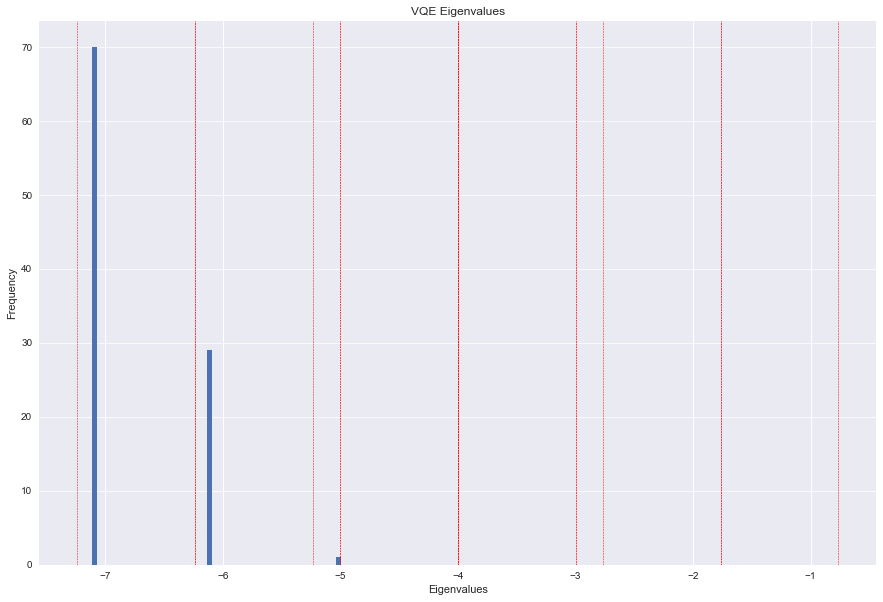

In [61]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.hist(np.array(final_E), 50)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.title('VQE Eigenvalues')

for i in range(len(egs)):
    plt.axvline(egs[i], linewidth=0.5, color='r', ls = '--')
    print(egs[i])

# Andre Ignore Anything Below Here!

In [64]:
### Test Circuits ###
#     qml.RX(params[8], wires=4)
#     qml.RY(params[9], wires=4)
#     qml.RX(params[10], wires=5)
#     qml.RY(params[11], wires=5)
    
#     qml.RX(params, wires=0)
#     qml.RY(params, wires=0)
#     qml.RX(params, wires=1)
#     qml.RY(params, wires=1)
#     qml.RX(params, wires=2)
#     qml.RY(params, wires=2)
#     qml.RX(params, wires=3)
#     qml.RY(params, wires=3)
#     qml.RX(params, wires=4)
#     qml.RY(params, wires=4)
#     qml.RX(params, wires=5)
#     qml.RY(params, wires=5)
    
#     qml.RX(params[0], wires=1)
#     qml.RY(params[1], wires=1)
    
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))
    
    # init_params = np.array([5.734882373784, 6.83295389245837, 4.832957289573298, 1.238974829785927398], requires_grad=True)

# init_params = np.array([4.97507603, 3.00854038, 5.339499404, 4.3929304], requires_grad=True)

# init_params = np.array([3.97507603, 3.00854038], requires_grad=True)

In [63]:
# Discretize the parameter space
theta0 = np.linspace(0.0, 2.0 * np.pi, 100)
theta1 = np.linspace(0.0, 2.0 * np.pi, 100)

# Load energy value at each point in parameter space
parameter_landscape = np.load("vqe_qng/param_landscape.npy")

# Plot energy landscape
fig, axes = plt.subplots(figsize=(6, 6))
cmap = plt.cm.get_cmap("coolwarm")
contour_plot = plt.contourf(theta0, theta1, parameter_landscape, cmap=cmap)
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")

# Plot optimization path for gradient descent. Plot every 10th point.
gd_color = "g"
plt.plot(
    np.array(gd_param_history)[::10, 0],
    np.array(gd_param_history)[::10, 1],
    ".",
    color=gd_color,
    linewidth=1,
    label="Gradient descent",
)
plt.plot(
    np.array(gd_param_history)[:, 0],
    np.array(gd_param_history)[:, 1],
    "-",
    color=gd_color,
    linewidth=1,
)

# Plot optimization path for quantum natural gradient descent. Plot every 10th point.
qngd_color = "k"
plt.plot(
    np.array(qngd_param_history)[::10, 0],
    np.array(qngd_param_history)[::10, 1],
    ".",
    color=qngd_color,
    linewidth=1,
    label="Quantum natural gradient descent",
)
plt.plot(
    np.array(qngd_param_history)[:, 0],
    np.array(qngd_param_history)[:, 1],
    "-",
    color=qngd_color,
    linewidth=1,
)

plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'vqe_qng/param_landscape.npy'

Here, the blue regions indicate states with lower energies, and the red
regions indicate states with higher energies. We can see that the
`QNGOptimizer` takes a more direct route to the minimum in larger
strides compared to the path taken by the `GradientDescentOptimizer`.

Lastly, we can visualize the same optimization paths on the Bloch sphere
using routines from [QuTiP](http://qutip.org/). The result should look
like the following:

![](/demonstrations/vqe_qng/opt_paths_bloch.png){.align-center
width="50.0%"}

where again the black markers and line indicate the path taken by the
`QNGOptimizer`, and the green markers and line indicate the path taken
by the `GradientDescentOptimizer`. Using this visualization method, we
can clearly see how the path using the `QNGOptimizer` tightly \"hugs\"
the curvature of the Bloch sphere and takes the shorter path.

Now, we will move onto a more interesting example: estimating the ground
state energy of molecular hydrogen.

Hydrogen VQE Example
====================

To construct our system Hamiltonian, we first read the molecular
geometry from the external file
`h2.xyz </demonstrations/h2.xyz>`{.interpreted-text role="download"}
using the `~.pennylane.qchem.read_structure`{.interpreted-text
role="func"} function (see more details in the
`tutorial_quantum_chemistry`{.interpreted-text role="doc"} tutorial).
The molecular Hamiltonian is then built using the
`~.pennylane.qchem.molecular_hamiltonian`{.interpreted-text role="func"}
function.


In [12]:
geo_file = "h2.xyz"

symbols, coordinates = qml.qchem.read_structure(geo_file)
hamiltonian, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

print("Number of qubits = ", qubits)

FileNotFoundError: [Errno 2] No such file or directory: 'h2.xyz'

For our ansatz, we use the circuit from the [VQE
tutorial](https://pennylane.ai/qml/demos/tutorial_vqe.html) but expand
out the arbitrary single-qubit rotations to elementary gates (RZ-RY-RZ).


In [ ]:
dev = qml.device("default.qubit", wires=qubits)
hf_state = np.array([1, 1, 0, 0], requires_grad=False)

def ansatz(params, wires=[0, 1, 2, 3]):
    qml.BasisState(hf_state, wires=wires)
    for i in wires:
        qml.RZ(params[3 * i], wires=i)
        qml.RY(params[3 * i + 1], wires=i)
        qml.RZ(params[3 * i + 2], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

Note that the qubit register has been initialized to $|1100\rangle$,
which encodes for the Hartree-Fock state of the hydrogen molecule
described in the minimal basis. Again, we define the cost function to be
the following QNode that measures `expval(H)`:


In [ ]:
@qml.qnode(dev, interface="autograd")
def cost(params):
    ansatz(params)
    return qml.expval(hamiltonian)

For this problem, we can compute the exact value of the ground state
energy via exact diagonalization. We provide the value below.


In [ ]:
exact_value = -1.136189454088

We now set up our optimizations runs.


In [ ]:
np.random.seed(0)
init_params = np.random.uniform(low=0, high=2 * np.pi, size=12, requires_grad=True)
max_iterations = 500
step_size = 0.5
conv_tol = 1e-06

As was done with our previous VQE example, we run the standard gradient
descent optimizer.


In [ ]:
opt = qml.GradientDescentOptimizer(step_size)

params = init_params

gd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    gd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print()
print("Final convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Next, we run the optimizer employing quantum natural gradients. We also
need to make the Hamiltonian coefficients non-differentiable by setting
`requires_grad=False`.


In [ ]:
hamiltonian = qml.Hamiltonian(np.array(hamiltonian.coeffs, requires_grad=False), hamiltonian.ops)

opt = qml.QNGOptimizer(step_size, lam=0.001, approx="block-diag")

params = init_params
prev_energy = cost(params)
qngd_cost = []

for n in range(max_iterations):
    params, prev_energy = opt.step_and_cost(cost, params)
    qngd_cost.append(prev_energy)

    energy = cost(params)
    conv = np.abs(energy - prev_energy)

    if n % 4 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} Ha".format(n, energy)
        )

    if conv <= conv_tol:
        break


print("\nFinal convergence parameter = {:.8f} Ha".format(conv))
print("Number of iterations = ", n)
print("Final value of the ground-state energy = {:.8f} Ha".format(energy))
print(
    "Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)".format(
        np.abs(energy - exact_value), np.abs(energy - exact_value) * 627.503
    )
)
print()
print("Final circuit parameters = \n", params)

Visualizing the results
=======================

To evaluate the performance of our two optimizers, we can compare: (a)
the number of steps it takes to reach our ground state estimate and (b)
the quality of our ground state estimate by comparing the final
optimization energy to the exact value.


In [ ]:
plt.style.use("seaborn")
plt.plot(np.array(gd_cost) - exact_value, "g", label="Gradient descent")
plt.plot(np.array(qngd_cost) - exact_value, "k", label="Quantum natural gradient descent")
plt.yscale("log")
plt.ylabel("Energy difference")
plt.xlabel("Step")
plt.legend()
plt.show()

We see that by employing quantum natural gradients, it takes fewer steps
to reach a ground state estimate and the optimized energy achieved by
the optimizer is lower than that obtained using vanilla gradient
descent.


Robustness in parameter initialization
======================================

While results above show a more rapid convergence for quantum natural
gradients, what if we were just lucky, i.e., we started at a \"good\"
point in parameter space? How do we know this will be the case with high
probability regardless of the parameter initialization?

Using the same system Hamiltonian, ansatz, and device, we tested the
robustness of the `QNGOptimizer` by running 10 independent trials with
random parameter initializations. For this numerical test, our optimizer
does not terminate based on energy improvement; we fix the number of
iterations to 200. We show the result of this test below (after
pre-computing), where we plot the mean and standard deviation of the
energies over optimization steps for quantum natural gradient and
standard gradient descent.

![](../demonstrations/vqe_qng/k_runs_.png){.align-center width="60.0%"}

We observe that quantum natural gradient on average converges faster for
this system.

::: {.note}
::: {.title}
Note
:::

While using QNG may help accelerate the VQE algorithm in terms of
optimization steps, each QNG step is more costly than its vanilla
gradient descent counterpart due to a greater number of calls to the
quantum computer that are needed to compute the Fubini-Study metric
tensor.
:::

While further benchmark studies are needed to better understand the
advantages of quantum natural gradient, preliminary studies such as this
tutorial show the potentials of the method. 🎉


References
==========

About the authors
=================
